# Linguistic Exploratory Data Analysis of Yoruba Corpora

## Objective
To identify key linguistic features of the Yorùbá language—such as tone
patterns, word structure, and culturally embedded expressions—through
computational data analysis, and to use these insights to inform the
design of a culturally aware Retrieval-Augmented Generation (RAG) system.


In [1]:
import numpy as np
import codecs
import torch
import pandas as pd
import ast
import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# import seaborn as sns
import pandas as pd
import re
from torch import nn
from torch.utils.data import Dataset, DataLoader
import re
import warnings
import os
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation 
import math
from collections import defaultdict, Counter
from itertools import combinations
from nltk.util import ngrams
from nltk import bigrams
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import pairwise_distances

In [2]:
path = "C:\\Users\\Lightified\\Desktop\\RAG\\Rag\\data\\"
files = os.listdir(path)
file = [path + fo for fo in files if fo.endswith('.csv')]

In [3]:
file


['C:\\Users\\Lightified\\Desktop\\RAG\\Rag\\data\\bbc_yoruba_news.csv',
 'C:\\Users\\Lightified\\Desktop\\RAG\\Rag\\data\\yankari_cleaned.csv',
 'C:\\Users\\Lightified\\Desktop\\RAG\\Rag\\data\\yoruba_books_mistral.csv',
 'C:\\Users\\Lightified\\Desktop\\RAG\\Rag\\data\\yoruba_text_dataset.csv']

## Corpus Description
The analysis uses an integrated Yoruba corpus derived from news,
cultural texts, and general language resources, covering domains
such as current affairs, religion, culture, and social life.


In [4]:
bbc_yor=pd.read_csv(file[0])
yankari=pd.read_csv(file[1])
book=pd.read_csv(file[2])
yor_text=pd.read_csv(file[3])

In [5]:
bbc_yor.drop(columns=['title', 'date'], inplace=True)
yankari.drop(columns=['type', 'source'], inplace=True)
yankari.rename(columns={'text': 'content'}, inplace=True)

In [6]:
bbc_yor['domain']=bbc_yor['domain'].str.lower()
yankari['domain']=yankari['domain'].str.lower()
book['domain']=book['domain'].str.lower()
yor_text['domain']=yor_text['domain'].str.lower()

In [7]:
yankari['domain'].replace({'fashion': 'social life'}, inplace=True)
yankari['domain'].replace({'sports': 'social life'}, inplace=True)
yankari['domain'].replace({'general': 'current affairs'}, inplace=True)
book['domain'].replace({'books': 'culture'}, inplace=True)
bbc_yor['domain'].replace({'current_affairs': 'current affairs'}, inplace=True)
bbc_yor['domain'].replace({'social_life': 'social life'}, inplace=True)

In [8]:
bbc_yor.domain.str.lower().unique(), yankari.domain.str.lower().unique(), book.domain.str.lower().unique(), yor_text.domain.str.lower().unique()

(array(['entertainment', 'current affairs', 'social life', 'culture',
        'religion'], dtype=object),
 array(['culture', 'current affairs', 'social life', 'entertainment'],
       dtype=object),
 array(['culture'], dtype=object),
 array(['religion', 'culture', 'social life', 'current affairs',
        'entertainment'], dtype=object))

In [9]:
data=pd.concat([bbc_yor, yankari, book, yor_text], ignore_index=True)
print(f"Shape of the combined data: {data.shape}")
data['content']=data['content'].str.replace('\n', ' ').str.replace('\r', ' ').str.replace('\t', ' ')
data['content']=data['content'].str.replace('  ', ' ').str.replace('  ', ' ').str.replace('  ', ' ')
data['content']=data['content'].str.strip()
data.drop_duplicates(subset=['content'], inplace=True)
print(f"Shape of the combined data after removing duplicates: {data.shape}")
data.reset_index(drop=True, inplace=True)




Shape of the combined data: (314390, 4)
Shape of the combined data after removing duplicates: (225566, 4)


In [10]:
data['word_count'] = data['content'].apply(lambda x: len(str(x).split()))

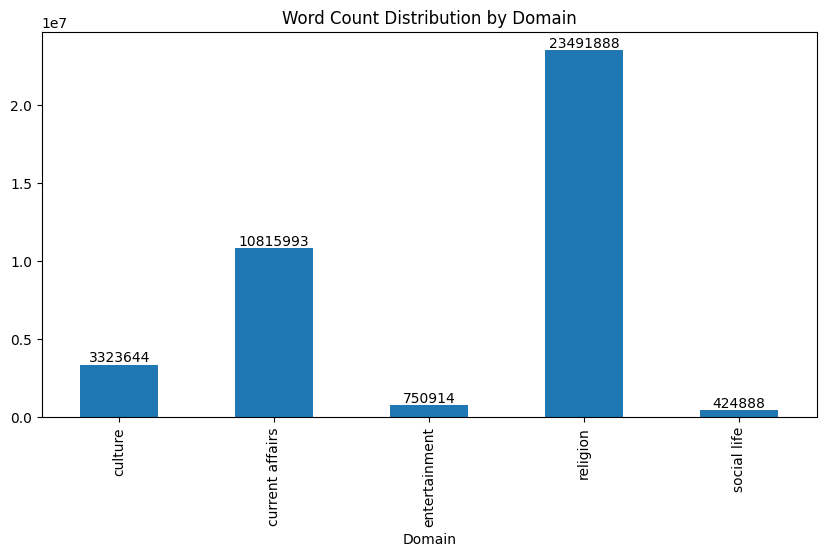

In [11]:
domain_word_counts = data.groupby('domain')['word_count'].sum()
ax = domain_word_counts.plot(kind='bar', title='Word Count Distribution by Domain', figsize=(10,5))
plt.xlabel('Domain')

# Annotate each bar with its value
for p in ax.patches:
    ax.annotate(str(int(p.get_height())), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=10)
plt.show()

In [12]:
data.content[0]

'wákàtí 4 sẹ́yìnAwuyewuye si n lọ lori bi ajọ to n ṣe amojuto igbohunsafẹfẹ ni Naijiria, National Broadcasting Commission (NBC), ti fofin de awọn ileeṣẹ igbohunsafẹfẹ - redio ati tẹlifisan – pe wọn wọn o gbọdọ gbe orin "Tell Your Papa", ti ogbatarigi akọrin takasufe, Eedris Abdulkareem, gbe sita lori afẹfẹ mọ.Lọjọ kẹsan an oṣu Kẹrin yii ni ajọ NBC sọ ninu atẹjade kan to fi sita pe orin naa ni awọn ọrọ to tọka abuku si ẹnikan ninu.Ṣugbọn kii ṣe igba akọkọ ti ajọ NBC yoo fofin de awọn ileeṣẹ igbohunsafẹfẹ wi pe wọn o gbọdọ gbe awọn orin kan tabi omiran safẹfẹ mọ ree.Wọnyii lawọn olorin ti ajọ NBC ti fofin de orin wọn tẹlẹ ni Naijiria:Davido – \'\'Fans Mi\'\'NBC fofin de awọn ileeṣẹ agbohunsafẹfẹ lọdun 2015 wi pe wọn o gbọ lo orin \'\'Fans Mi\'\' ti Davido gbe jade mọ.Ọrin ọhun ti olorin orilẹede Amẹrika Meek Mill naa jade ninu rẹ ni ajọ NBC sọ pe wọn lo egboogi oloro kan ti ko yẹ ki wọn lo ninu fidio orin naa..Ajọ NBC tun sọ pe awọn eeyan to n ṣira silẹ wa ninu fidio orin ọhun eyi ti ko 

In [13]:

from yoruba_preprocess import preprocess_yoruba, preprocess_list


In [14]:
data['cleaned_content'] = data['content'].apply(preprocess_yoruba)

In [44]:
YORUBA_STOPWORDS = {
    "ṣadùró", "ṣagbè", "ṣagbé", "ṣàbì", "ṣe", "ṣè", "ṣé", "ṣepọ", "ṣepọ̀",
    "ṣeéṣe", "ṣe e", "ṣeni", "ṣeni tí", "ṣeni to", "ṣi", "ṣì", "ṣí", "ṣii",
    "ṣígọ", "ṣigọ", "ṣòro", "ṣoro", "ṣòrọ̀", "ṣọ", "ṣọ̀", "ṣọ́", "ṣọ̀kan",
    "ṣọkan", "ṣọ̀kan si", "ṣọ̀kan", "sọ", "wo", "á", "bo", "wi", "w", "v",
    "fe", "ri", "pẹlu", "lọwọ", "jowo", "jẹ́", "jẹ", "ń", "ńṣe",
    "ńkọ́", "ńjẹ́", "ló", "nípa", "yín", "nnkan", "lowo", "fẹ",
    "yẹ", "un", "ge", "nla", "ye", "já", "fa", "nii", "daadaa",
    "ree", "ke", "ṣẹ", "ku", "nigba", "fẹẹ", "nipa", "lawọn",
    "gẹgẹ", "sportsinyorubagmailcom", "httpwwwtwittercomsportsinyoruba",
    "ẹọ", "pẹlú", "wipe", "ṣl",'one',"one",'bbm','us','lé',
}
import re

def remove_stopwords(text: str, stopwords: set) -> str:
    if not isinstance(text, str):
        return text  # safety for NaN or non-text rows

    tokens = re.findall(r"\b\w+\b", text.lower(), flags=re.UNICODE)
    cleaned = [t for t in tokens if t not in stopwords]
    return " ".join(cleaned)


data.content = remove_stopwords(data.cleaned_content, YORUBA_STOPWORDS)

In [45]:
entertainment = data[data['domain']=='entertainment']
curr_affairs = data[data['domain']=='current affairs']
social_life = data[data['domain']=='social life']
culture = data[data['domain']=='culture']
religion = data[data['domain']=='religion']


In [ ]:
#entertainment['content']=entertainment['content'].apply(preprocess_yoruba)
#curr_affairs['content']=curr_affairs['content'].apply(preprocess_yoruba)   
#social_life['content']=social_life['content'].apply(preprocess_yoruba)
#culture['content']=culture['content'].apply(preprocess_yoruba)
#religion['content']=religion['content'].apply(preprocess_yoruba) 

In [46]:
from tqdm import tqdm
all_ent = " " + " ".join(entertainment['content'].values)
all_curr = " " + " ".join(curr_affairs['content'].values)
all_soc = " " + " ".join(social_life['content'].values)
all_cul = " " + " ".join(culture['content'].values)
all_rel = " " + " ".join(religion['content'].values)
word_cnt_ent= {}
for i in tqdm(all_ent.split()): word_cnt_ent[i] = word_cnt_ent.get(i, 0) + 1
word_cnt_curr= {}
for i in tqdm(all_curr.split()): word_cnt_curr[i] = word_cnt_curr.get(i, 0) + 1
word_cnt_soc= {}
for i in tqdm(all_soc.split()): word_cnt_soc[i] = word_cnt_soc.get(i, 0) + 1
word_cnt_cul= {}
for i in tqdm(all_cul.split()): word_cnt_cul[i] = word_cnt_cul.get(i, 0) + 1
word_cnt_rel= {}
for i in tqdm(all_rel.split()): word_cnt_rel[i] = word_cnt_rel.get(i, 0) + 1


100%|██████████| 168391/168391 [00:00<00:00, 474421.43it/s]

100%|██████████| 1403280/1403280 [00:03<00:00, 407061.93it/s]

100%|██████████| 8379913/8379913 [00:23<00:00, 359442.29it/s]


In [47]:
word_cnt_rel

{'ẹrẹnà': 5,
 'ṣọṣlónìí': 1,
 'ọgbọn': 6275,
 'oṣù': 4027,
 'kẹta': 1221,
 'ṣọṣ': 24,
 'ìtunu': 1,
 'ààwẹ': 165,
 'ramadan': 25,
 'fáwọn': 6316,
 'mùsùlùmí': 94,
 'sultan': 2,
 'sokoto': 1,
 'alhaji': 14,
 'saad': 1,
 'abubakar': 1,
 'kéde': 1440,
 'lálẹ': 459,
 'àbámẹta': 1,
 'kọkàndínlọgbọn': 20,
 'oṣu': 24,
 'shawwal': 13,
 'nàìjíríàèyí': 1,
 'túmọ': 5838,
 'wẹjẹ': 1,
 'wẹmu': 2,
 'bẹrẹ': 14529,
 'padà': 11125,
 'lẹyìn': 19729,
 'gbígba': 420,
 'mọkàndínlọgbọn': 62,
 'eidelfitrgẹgẹ': 1,
 'ẹsìn': 3734,
 'islam': 64,
 'kalẹ': 2692,
 'gbọdọ': 12477,
 'mẹwàá': 2560,
 'lọjọ': 3875,
 'dùn': 8217,
 'wọnsheikh': 1,
 'nuru': 1,
 'khalid': 1,
 'onímọ': 1286,
 'abuja': 1,
 'ibújókòó': 1,
 'nílò': 3843,
 'eidel': 1,
 'fitr': 1,
 'bbcàwọn': 1,
 'nìyí': 1690,
 'ṣọṣeto': 1,
 'isinku': 14,
 'pope': 181,
 'francis': 104,
 'waye': 18,
 'vatican': 159,
 'owurọ': 6,
 'abamẹta': 1,
 'kẹrindinlọgbọn': 4,
 'kẹrinọjọ': 1,
 'aje': 6,
 'lẹni': 927,
 'mejidinlọgọrinsaaju': 1,
 'aworan': 2,
 'oloogbe': 3,
 'po

In [48]:
word_ordered_ent = sorted(word_cnt_ent, key=lambda x: word_cnt_ent[x], reverse=True)
top_20_ent = word_ordered_ent[:20]
cnt_20_ent = {word: word_cnt_ent[word] for word in top_20_ent}
print("Top 20 words in Entertainment domain:")
print(cnt_20_ent)

word_ordered_curr = sorted(word_cnt_curr, key=lambda x: word_cnt_curr[x], reverse=True)
top_20_curr = word_ordered_curr[:20]
cnt_20_curr = {word: word_cnt_curr[word] for word in top_20_curr}
print("Top 20 words in Current Events domain:")
print(cnt_20_curr)
word_ordered_soc = sorted(word_cnt_soc, key=lambda x: word_cnt_soc[x], reverse=True)
top_20_soc = word_ordered_soc[:20]
cnt_20_soc = {word: word_cnt_soc[word] for word in top_20_soc}
print("Top 20 words in Social Life domain:")
print(cnt_20_soc)
word_ordered_cul = sorted(word_cnt_cul, key=lambda x: word_cnt_cul[x], reverse=True)
top_20_cul = word_ordered_cul[:20]
cnt_20_cul = {word: word_cnt_cul[word] for word in top_20_cul}
print("Top 20 words in Culture domain:")
print(cnt_20_cul)
word_ordered_rel = sorted(word_cnt_rel, key=lambda x: word_cnt_rel[x], reverse=True)
top_20_rel = word_ordered_rel[:20]
cnt_20_rel = {word: word_cnt_rel[word] for word in top_20_rel}
print("Top 20 words in Religion domain:")
print(cnt_20_rel)


Top 20 words in Entertainment domain:
{'gomina': 2351, 'eto': 2194, 'eko': 2165, 'ọmọ': 2092, 'iṣẹ': 1877, 'ẹgbẹ': 1753, 'sọrọ': 1068, 'egbe': 1051, 'paapaa': 1049, 'araalu': 1017, 'sanwoolu': 1007, 'ileeṣẹ': 992, 'bẹrẹ': 976, 'ise': 955, 'bayii': 935, 'yoruba': 934, 'odun': 921, 'tawọn': 909, 'tinubu': 906, 'omo': 906}
Top 20 words in Current Events domain:
{'ọmọ': 46064, 'ẹgbẹ': 32396, 'naijiria': 26439, 'ipinlẹ': 26334, 'ọlọpaa': 24061, 'iṣẹ': 19341, 'oṣu': 18986, 'gomina': 17964, 'eto': 17871, 'lẹyin': 17117, 'aarẹ': 14926, 'bẹrẹ': 14554, 'waye': 14457, 'eko': 13473, 'lọjọ': 13400, 'ileeṣẹ': 13043, 'sọrọ': 12663, 'nipinlẹ': 12241, 'silẹ': 12212, 'bayii': 12070}
Top 20 words in Social Life domain:
{'bbm': 2407, 'feran': 2180, 'madrid': 1878, 'ipolowo': 1669, 'boolu': 1664, 'egbe': 1335, 'alayo': 1273, 'olajuwon': 1270, 'abolade': 1260, 'ryan': 1218, 'channel': 1202, 'httppinbbmcomcọọẹc': 1193, 'kika': 1184, 'home': 1093, 'siwa': 1082, 'ju': 1021, 'ofe': 1015, 'last': 986, 'ẹedṣ': 97

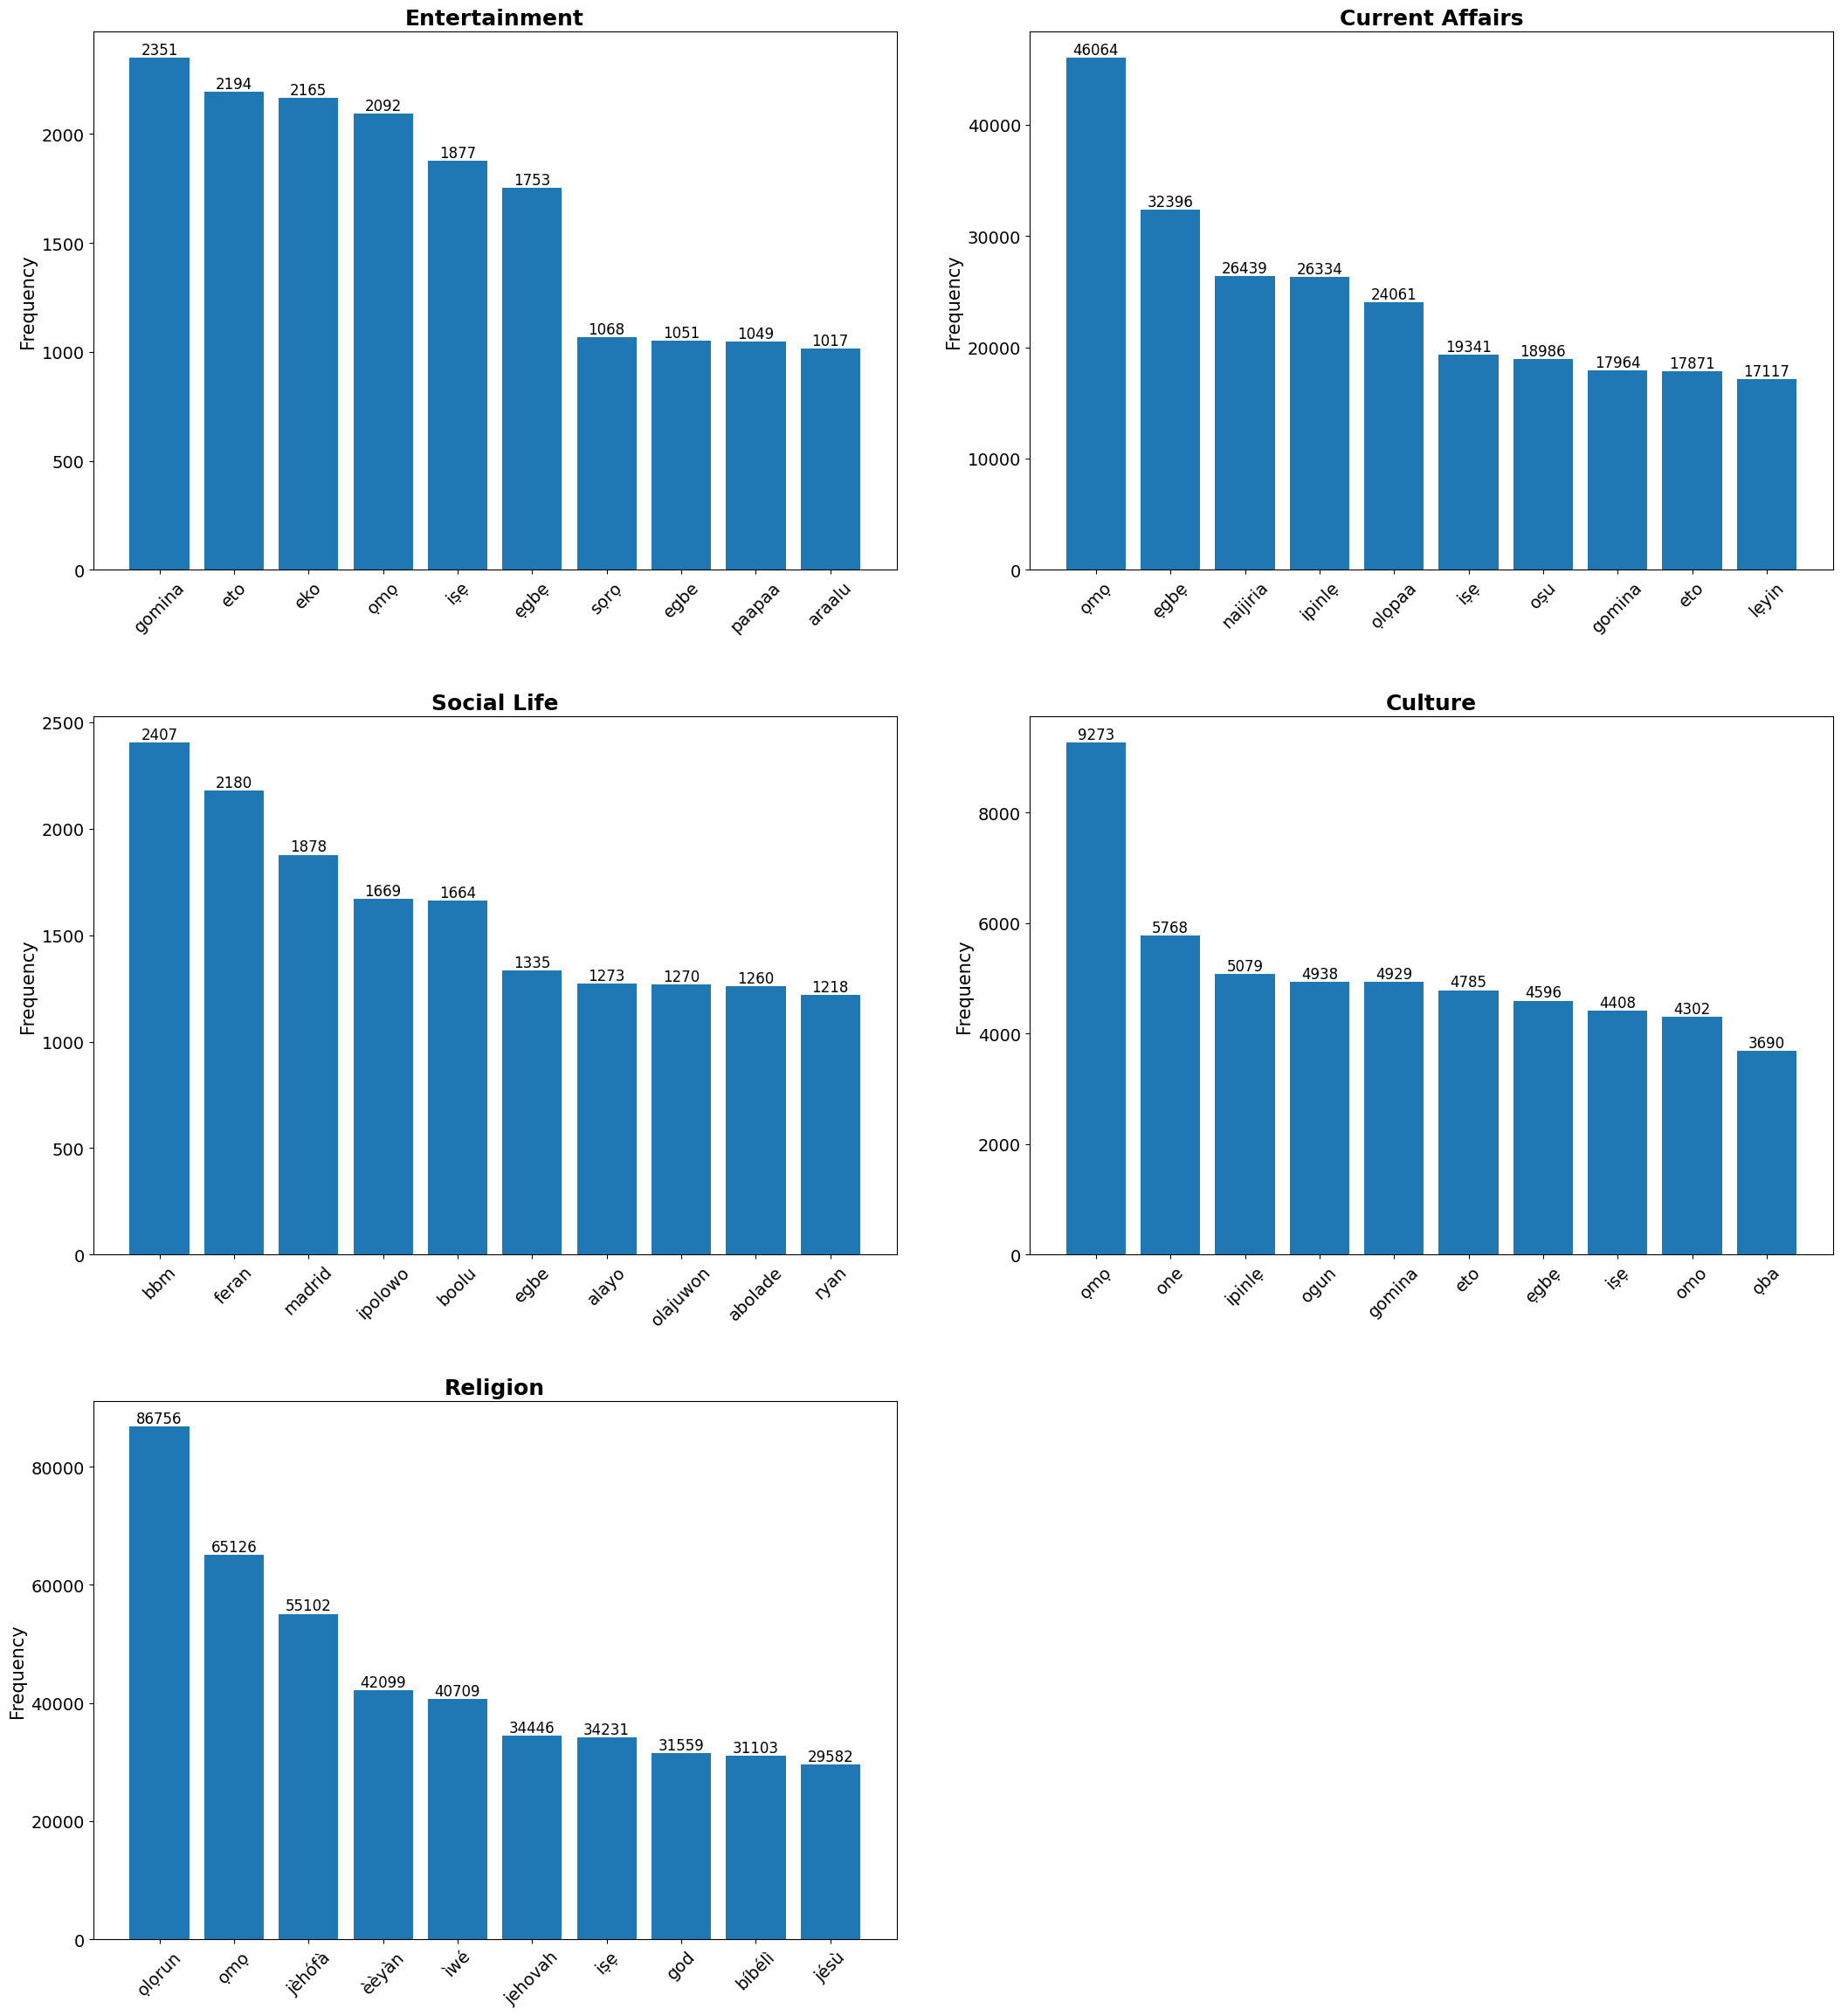

In [34]:
import matplotlib.pyplot as plt

TOP_N = 10

fig, axes = plt.subplots(3, 2, figsize=(22, 24))
axes = axes.flatten()

def plot_bar(ax, words, counts, title):
    values = [counts[w] for w in words[:TOP_N]]
    bars = ax.bar(words[:TOP_N], values)

    ax.set_title(title, fontsize=18, fontweight="bold")
    ax.set_ylabel("Frequency", fontsize=15)
    ax.tick_params(axis='x', labelrotation=45, labelsize=14)
    ax.tick_params(axis='y', labelsize=14)

    # Add value labels on top of bars
    for bar, val in zip(bars, values):
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            bar.get_height(),
            str(val),
            ha="center",
            va="bottom",
            fontsize=12
        )

plot_bar(axes[0], top_20_ent, cnt_20_ent, "Entertainment")
plot_bar(axes[1], top_20_curr, cnt_20_curr, "Current Affairs")
plot_bar(axes[2], top_20_soc, cnt_20_soc, "Social Life")
plot_bar(axes[3], top_20_cul, cnt_20_cul, "Culture")
plot_bar(axes[4], top_20_rel, cnt_20_rel, "Religion")

axes[5].axis("off")

plt.tight_layout(pad=4.0)
plt.show()


In [27]:
import plotly.subplots as sp
import plotly.graph_objects as go

fig = sp.make_subplots(rows=1, cols=5, subplot_titles=[
    "Entertainment", "Current Affairs", "Social Life", "Culture", "Religion"
])

fig.add_trace(go.Bar(x=top_20_ent, y=[cnt_20_ent[w] for w in top_20_ent], name="Entertainment"), row=1, col=1)
fig.add_trace(go.Bar(x=top_20_curr, y=[cnt_20_curr[w] for w in top_20_curr], name="Current Affairs"), row=1, col=2)
fig.add_trace(go.Bar(x=top_20_soc, y=[cnt_20_soc[w] for w in top_20_soc], name="Social Life"), row=1, col=3)
fig.add_trace(go.Bar(x=top_20_cul, y=[cnt_20_cul[w] for w in top_20_cul], name="Culture"), row=1, col=4)
fig.add_trace(go.Bar(x=top_20_rel, y=[cnt_20_rel[w] for w in top_20_rel], name="Religion"), row=1, col=5)

fig.update_layout(height=500, width=1800, showlegend=False)
fig.show()


In [32]:
# Yoruba-friendly tokenizer: split on word boundaries and keep diacritics
def yoruba_tokenizer(text):
    tokens = re.findall(r"[\wẹọṣáéíóúàèìòù]+", text, re.UNICODE)
    return tokens


entertainment_tokens = yoruba_tokenizer(all_ent)
curr_affairs_tokens = yoruba_tokenizer(all_curr)
social_life_tokens = yoruba_tokenizer(all_soc)
culture_tokens = yoruba_tokenizer(all_cul)
religion_tokens = yoruba_tokenizer(all_rel)

Entertainment Token Stats: (286504, 23462) Most Common: [('gomina', 2351), ('eto', 2194), ('eko', 2165), ('ọmọ', 2092), ('iṣẹ', 1877), ('ẹgbẹ', 1753), ('sọrọ', 1068), ('egbe', 1051), ('paapaa', 1049), ('araalu', 1017)]
Current Affairs Token Stats: (4590805, 224702) Most Common: [('ọmọ', 46064), ('ẹgbẹ', 32396), ('naijiria', 26439), ('ipinlẹ', 26334), ('ọlọpaa', 24061), ('iṣẹ', 19341), ('oṣu', 18986), ('gomina', 17964), ('eto', 17871), ('lẹyin', 17117)]
Social Life Token Stats: (168391, 16216) Most Common: [('bbm', 2407), ('feran', 2180), ('madrid', 1878), ('ipolowo', 1669), ('boolu', 1664), ('egbe', 1335), ('alayo', 1273), ('olajuwon', 1270), ('abolade', 1260), ('ryan', 1218)]
Culture Token Stats: (1403280, 161107) Most Common: [('ọmọ', 9273), ('one', 5768), ('ipinlẹ', 5079), ('ogun', 4938), ('gomina', 4929), ('eto', 4785), ('ẹgbẹ', 4596), ('iṣẹ', 4408), ('omo', 4302), ('ọba', 3690)]
Religion Token Stats: (8379913, 124180) Most Common: [('ọlọrun', 86756), ('ọmọ', 65126), ('jèhófà', 551

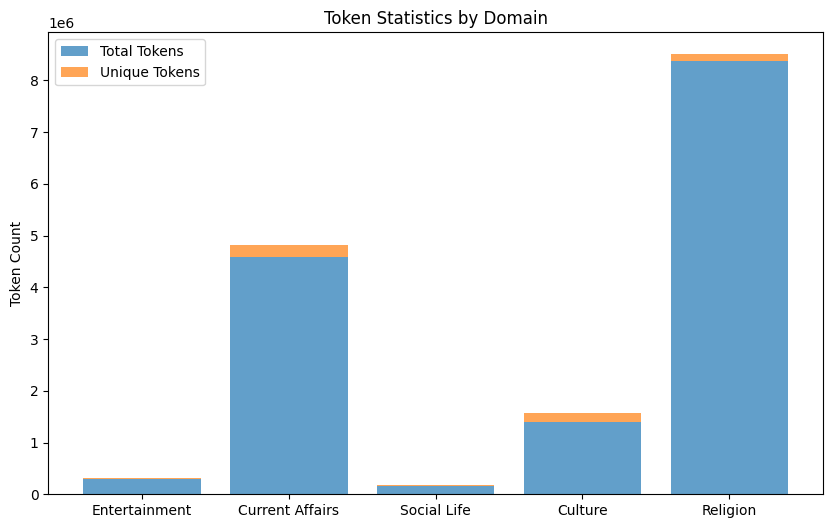

In [33]:
# Token count and unique word frequency
def token_stats(tokens):
    total_tokens = len(tokens)
    unique_tokens = set(tokens)
    unique_count = len(unique_tokens)
    freq_dist = Counter(tokens)
    most_common = freq_dist.most_common(10)
    return total_tokens, unique_count, freq_dist, most_common
ent_stats = token_stats(entertainment_tokens)
curr_stats = token_stats(curr_affairs_tokens)
soc_stats = token_stats(social_life_tokens)
cul_stats = token_stats(culture_tokens)
rel_stats = token_stats(religion_tokens)

print("Entertainment Token Stats:", ent_stats[:2], "Most Common:", ent_stats[3])
print("Current Affairs Token Stats:", curr_stats[:2], "Most Common:", curr_stats[3])
print("Social Life Token Stats:", soc_stats[:2], "Most Common:", soc_stats[3])
print("Culture Token Stats:", cul_stats[:2], "Most Common:", cul_stats[3])
print("Religion Token Stats:", rel_stats[:2], "Most Common:", rel_stats[3])
import matplotlib.pyplot as plt

domains = ['Entertainment', 'Current Affairs', 'Social Life', 'Culture', 'Religion']
total_tokens = [ent_stats[0], curr_stats[0], soc_stats[0], cul_stats[0], rel_stats[0]]
unique_tokens = [ent_stats[1], curr_stats[1], soc_stats[1], cul_stats[1], rel_stats[1]]

fig, ax = plt.subplots(figsize=(10,6))
bar1 = ax.bar(domains, total_tokens, label='Total Tokens', alpha=0.7)
bar2 = ax.bar(domains, unique_tokens, label='Unique Tokens', alpha=0.7, bottom=total_tokens)

ax.set_ylabel('Token Count')
ax.set_title('Token Statistics by Domain')
ax.legend()
plt.show()

# Annotate each bar with its value
for i, rect in enumerate(bar1):
    height = rect.get_height()
    ax.annotate(f'{height:,}', 
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)

for i, rect in enumerate(bar2):
    height = rect.get_height()
    ax.annotate(f'{unique_tokens[i]:,}', 
                xy=(rect.get_x() + rect.get_width() / 2, total_tokens[i] + height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom', fontsize=10)


Entertainment: 286504 23462 [('gomina', 2351), ('eto', 2194), ('eko', 2165), ('ọmọ', 2092), ('iṣẹ', 1877), ('ẹgbẹ', 1753), ('sọrọ', 1068), ('egbe', 1051), ('paapaa', 1049), ('araalu', 1017)]
Current Affairs: 4590805 224702 [('ọmọ', 46064), ('ẹgbẹ', 32396), ('naijiria', 26439), ('ipinlẹ', 26334), ('ọlọpaa', 24061), ('iṣẹ', 19341), ('oṣu', 18986), ('gomina', 17964), ('eto', 17871), ('lẹyin', 17117)]
Social Life: 168391 16216 [('bbm', 2407), ('feran', 2180), ('madrid', 1878), ('ipolowo', 1669), ('boolu', 1664), ('egbe', 1335), ('alayo', 1273), ('olajuwon', 1270), ('abolade', 1260), ('ryan', 1218)]
Culture: 1403280 161107 [('ọmọ', 9273), ('one', 5768), ('ipinlẹ', 5079), ('ogun', 4938), ('gomina', 4929), ('eto', 4785), ('ẹgbẹ', 4596), ('iṣẹ', 4408), ('omo', 4302), ('ọba', 3690)]
Religion: 8379913 124180 [('ọlọrun', 86756), ('ọmọ', 65126), ('jèhófà', 55102), ('èèyàn', 42099), ('ìwé', 40709), ('jehovah', 34446), ('iṣẹ', 34231), ('god', 31559), ('bíbélì', 31103), ('jésù', 29582)]


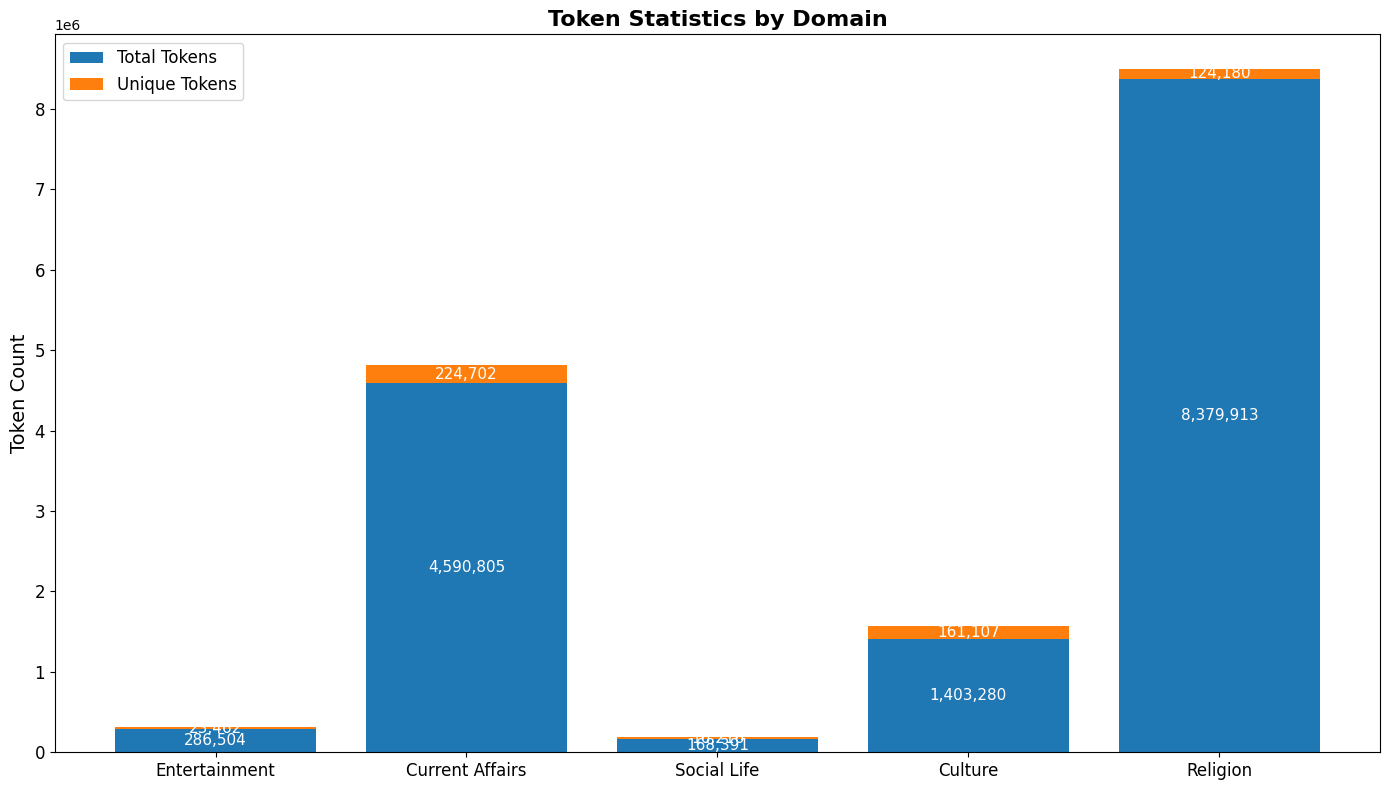

In [39]:
from collections import Counter

def token_stats(tokens, top_n=10):
    total_tokens = len(tokens)
    unique_tokens = len(set(tokens))
    freq_dist = Counter(tokens)
    most_common = freq_dist.most_common(top_n)
    return {
        "total": total_tokens,
        "unique": unique_tokens,
        "freq": freq_dist,
        "top": most_common
    }
ent_stats  = token_stats(entertainment_tokens)
curr_stats = token_stats(curr_affairs_tokens)
soc_stats  = token_stats(social_life_tokens)
cul_stats  = token_stats(culture_tokens)
rel_stats  = token_stats(religion_tokens)

print("Entertainment:", ent_stats["total"], ent_stats["unique"], ent_stats["top"])
print("Current Affairs:", curr_stats["total"], curr_stats["unique"], curr_stats["top"])
print("Social Life:", soc_stats["total"], soc_stats["unique"], soc_stats["top"])
print("Culture:", cul_stats["total"], cul_stats["unique"], cul_stats["top"])
print("Religion:", rel_stats["total"], rel_stats["unique"], rel_stats["top"])

import matplotlib.pyplot as plt

domains = ['Entertainment', 'Current Affairs', 'Social Life', 'Culture', 'Religion']

total_tokens = [
    ent_stats["total"],
    curr_stats["total"],
    soc_stats["total"],
    cul_stats["total"],
    rel_stats["total"]
]

unique_tokens = [
    ent_stats["unique"],
    curr_stats["unique"],
    soc_stats["unique"],
    cul_stats["unique"],
    rel_stats["unique"]
]

fig, ax = plt.subplots(figsize=(14, 8))

bar1 = ax.bar(domains, total_tokens, label='Total Tokens')
bar2 = ax.bar(domains, unique_tokens, bottom=total_tokens, label='Unique Tokens')

ax.set_ylabel('Token Count', fontsize=14)
ax.set_title('Token Statistics by Domain', fontsize=16, fontweight='bold')
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.legend(fontsize=12)
# Label TOTAL tokens (centered inside bottom bar)
for rect in bar1:
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        height / 2,
        f'{int(height):,}',
        ha='center',
        va='center',
        fontsize=11,
        color='white'
    )

# Label UNIQUE tokens (centered inside top stacked bar)
for rect, total, unique in zip(bar2, total_tokens, unique_tokens):
    ax.text(
        rect.get_x() + rect.get_width() / 2,
        total + rect.get_height() / 2,
        f'{int(unique):,}',
        ha='center',
        va='center',
        fontsize=11,
        color='white'
    )
plt.tight_layout()
plt.show()



In [40]:
def join_text(series):
    return " ".join(series.dropna().astype(str).values)

ent_words  = join_text(entertainment["content"])
curr_words = join_text(curr_affairs["content"])
soc_words  = join_text(social_life["content"])
cul_words  = join_text(culture["content"])
rel_words  = join_text(religion["content"])


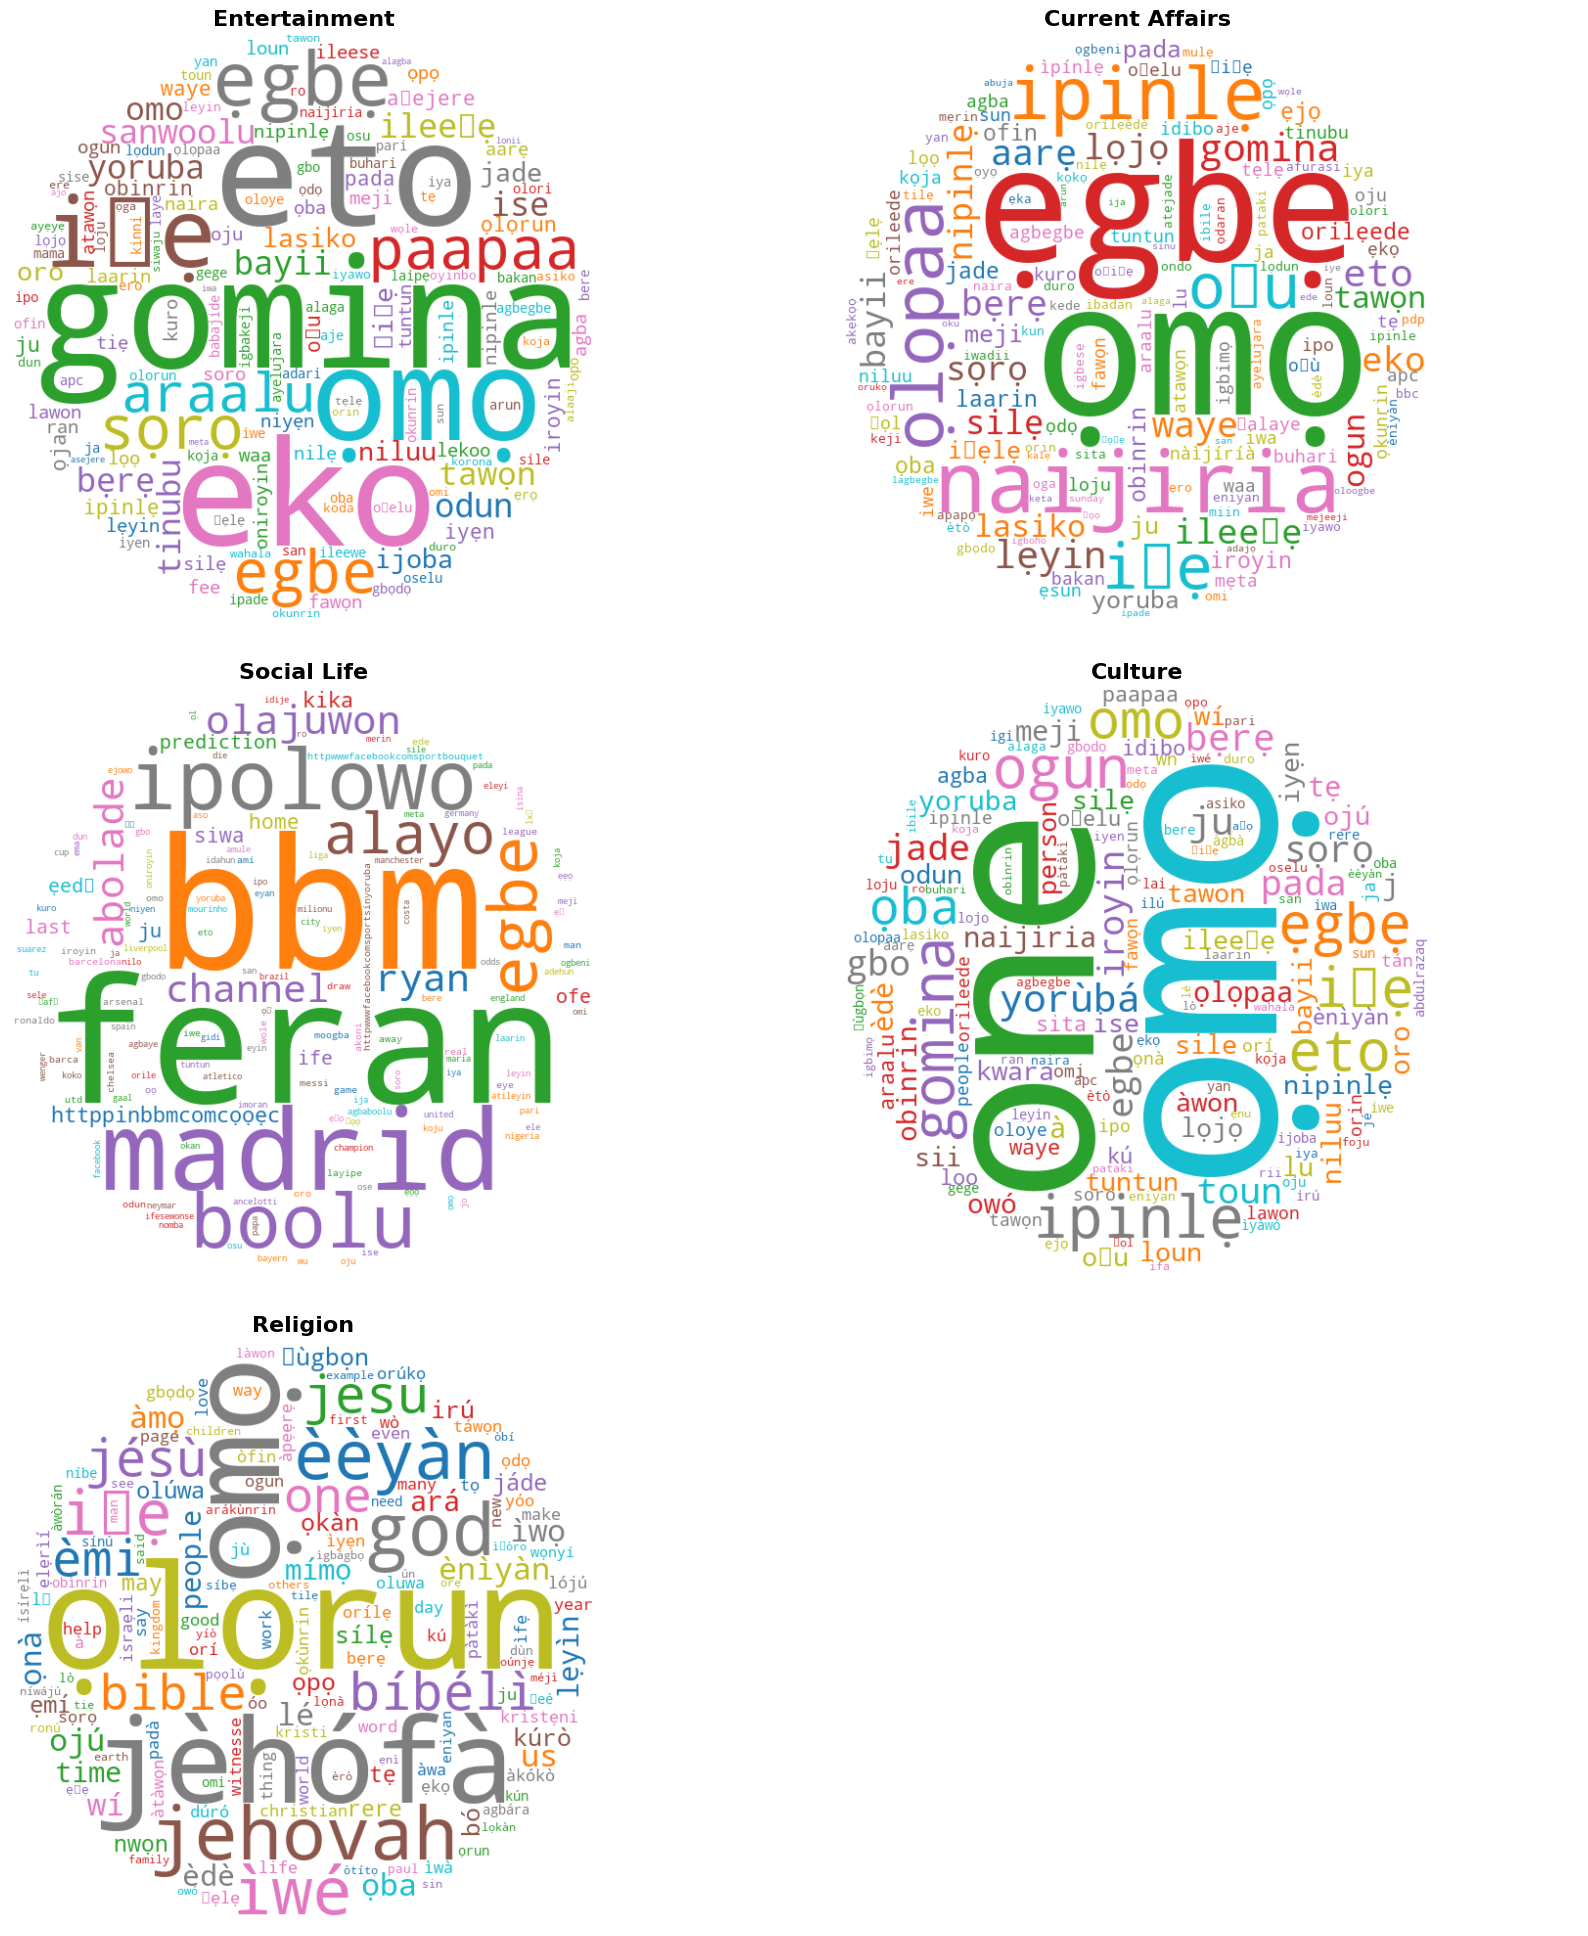

In [43]:
import numpy as np
from PIL import Image

def create_circular_mask(diameter=600):
    # Create a circular mask with white background
    x, y = np.ogrid[:diameter, :diameter]
    center = (diameter / 2, diameter / 2)
    radius = diameter / 2
    mask = (x - center[0])**2 + (y - center[1])**2 > radius**2
    mask = 255 * mask.astype(np.uint8)  # white outside, black inside
    return mask
from wordcloud import WordCloud
import matplotlib.pyplot as plt

mask = create_circular_mask(600)

wc_params = dict(
    width=600,
    height=600,
    background_color="white",
    mask=mask,
    colormap="tab10",   # color palette for readability
    max_words=150,
    relative_scaling=0.5,
    collocations=False
)

wc_ent  = WordCloud(**wc_params).generate(ent_words)
wc_curr = WordCloud(**wc_params).generate(curr_words)
wc_soc  = WordCloud(**wc_params).generate(soc_words)
wc_cul  = WordCloud(**wc_params).generate(cul_words)
wc_rel  = WordCloud(**wc_params).generate(rel_words)

fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()

wordclouds = [wc_ent, wc_curr, wc_soc, wc_cul, wc_rel]
titles = ['Entertainment', 'Current Affairs', 'Social Life', 'Culture', 'Religion']

for ax, wc, title in zip(axes[:5], wordclouds, titles):
    ax.imshow(wc, interpolation="bilinear")
    ax.set_title(title, fontsize=16, fontweight="bold")
    ax.axis("off")

# Hide unused subplot
axes[5].axis("off")

plt.tight_layout(pad=3.0)
plt.show()


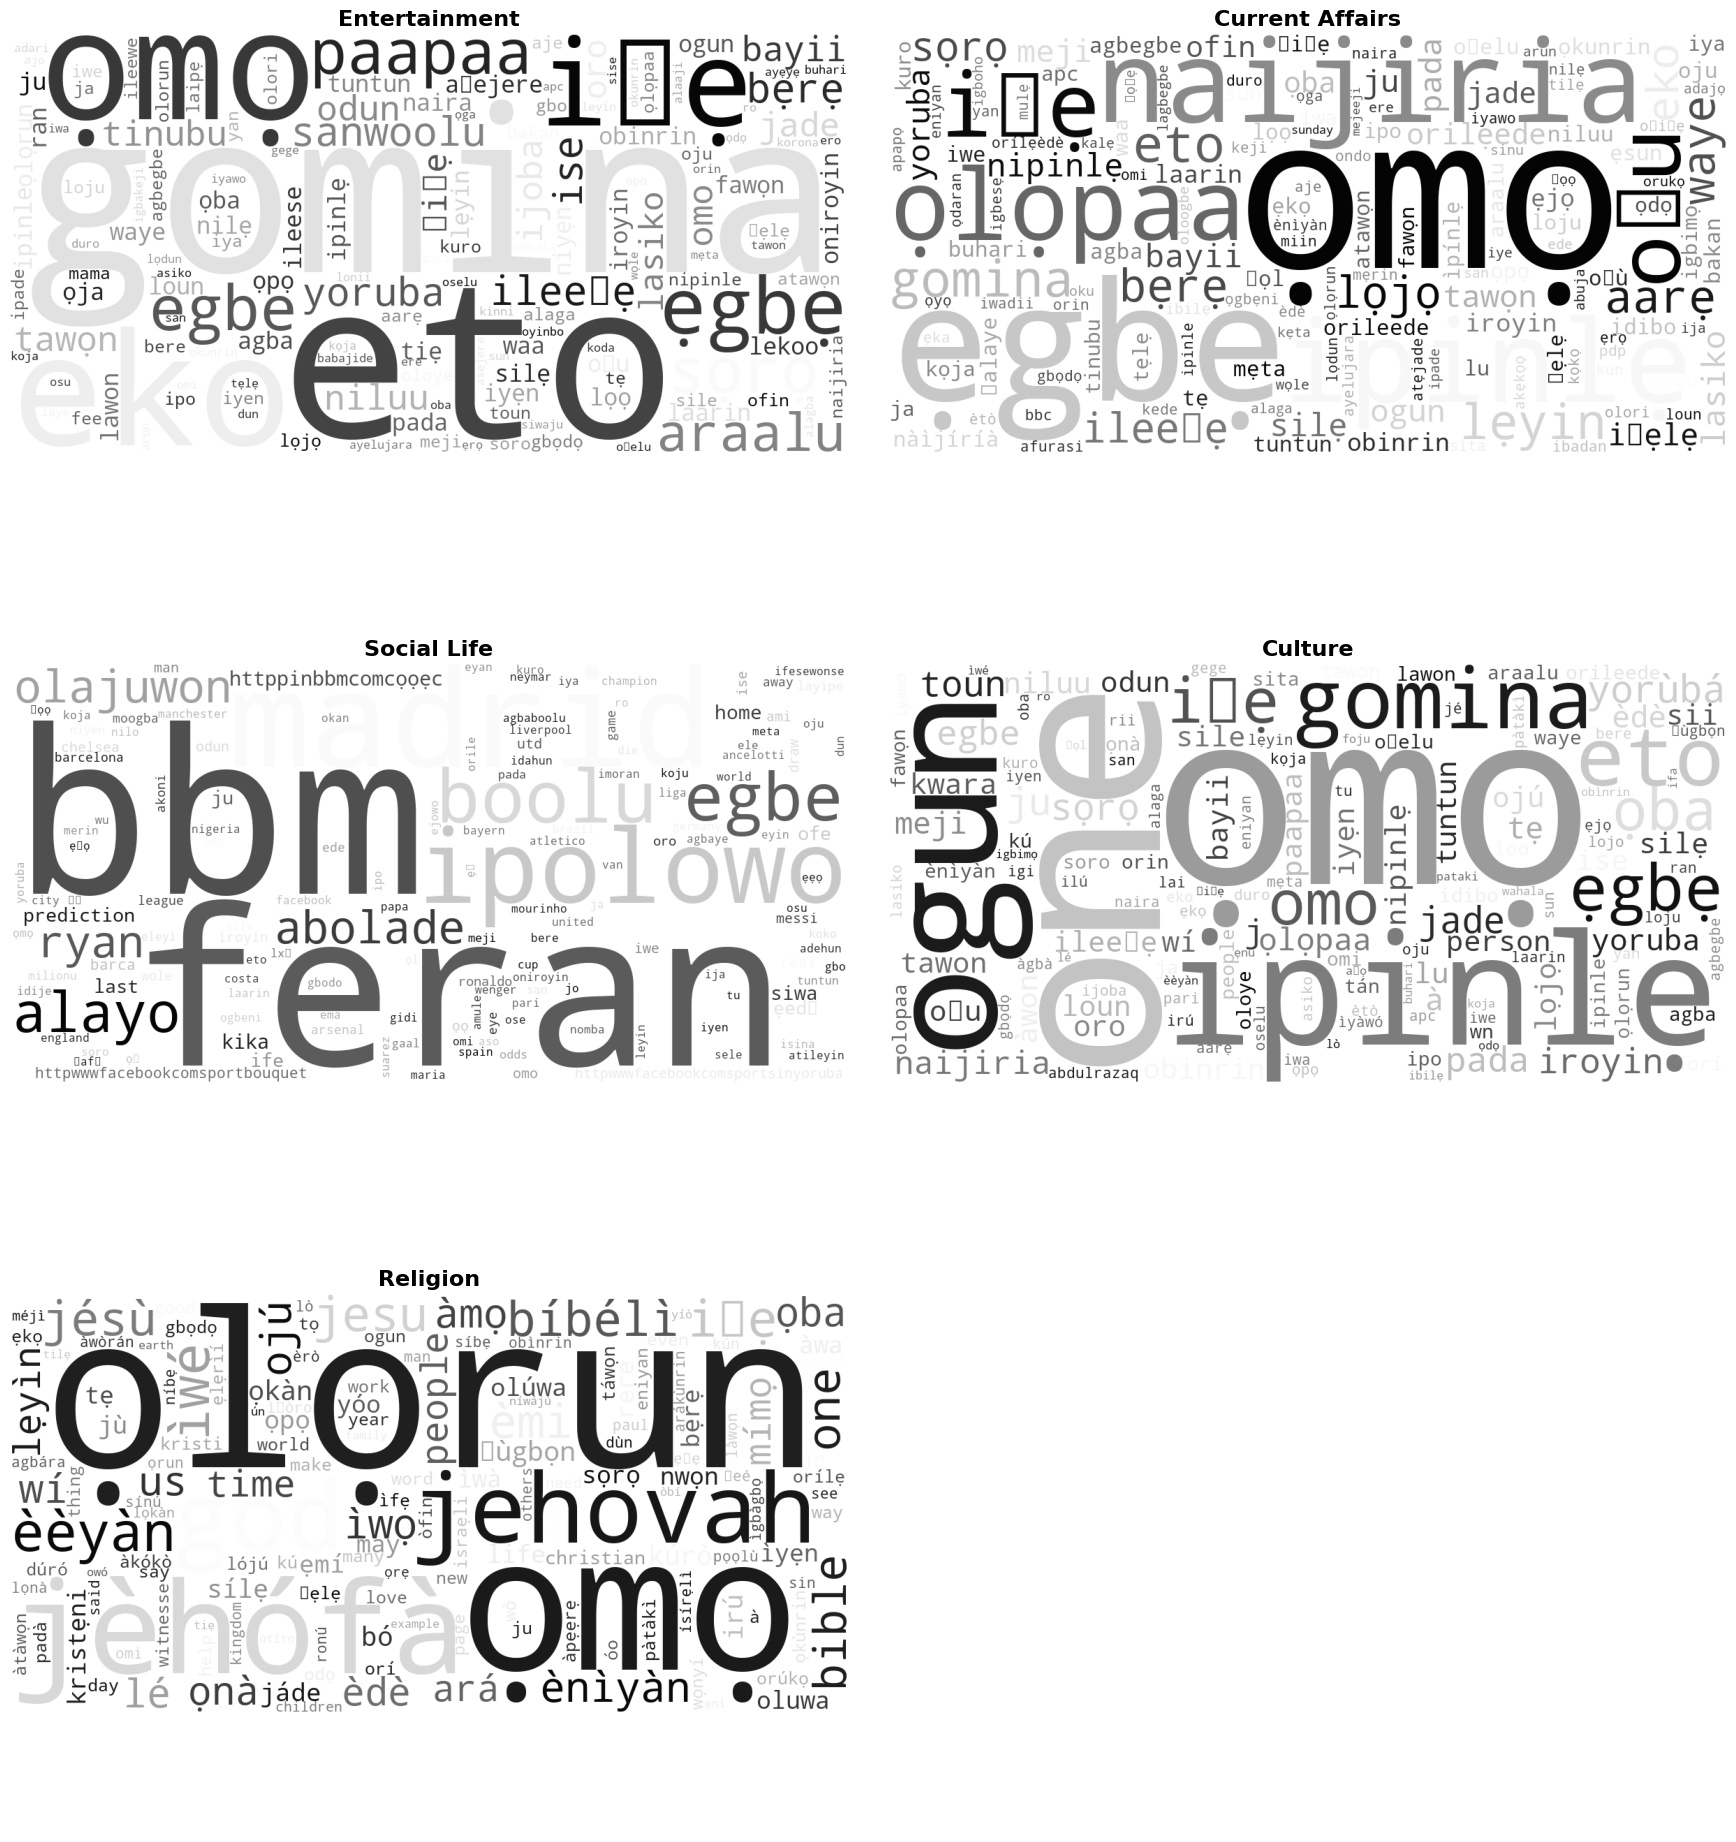

In [42]:
fig, axes = plt.subplots(3, 2, figsize=(18, 20))
axes = axes.flatten()

axes[0].imshow(wc_ent)
axes[0].set_title("Entertainment", fontsize=16, fontweight="bold")

axes[1].imshow(wc_curr)
axes[1].set_title("Current Affairs", fontsize=16, fontweight="bold")

axes[2].imshow(wc_soc)
axes[2].set_title("Social Life", fontsize=16, fontweight="bold")

axes[3].imshow(wc_cul)
axes[3].set_title("Culture", fontsize=16, fontweight="bold")

axes[4].imshow(wc_rel)
axes[4].set_title("Religion", fontsize=16, fontweight="bold")

# Hide unused subplot
axes[5].axis("off")

# Remove axes for all word clouds
for ax in axes[:5]:
    ax.axis("off")

plt.tight_layout(pad=3.0)
plt.show()


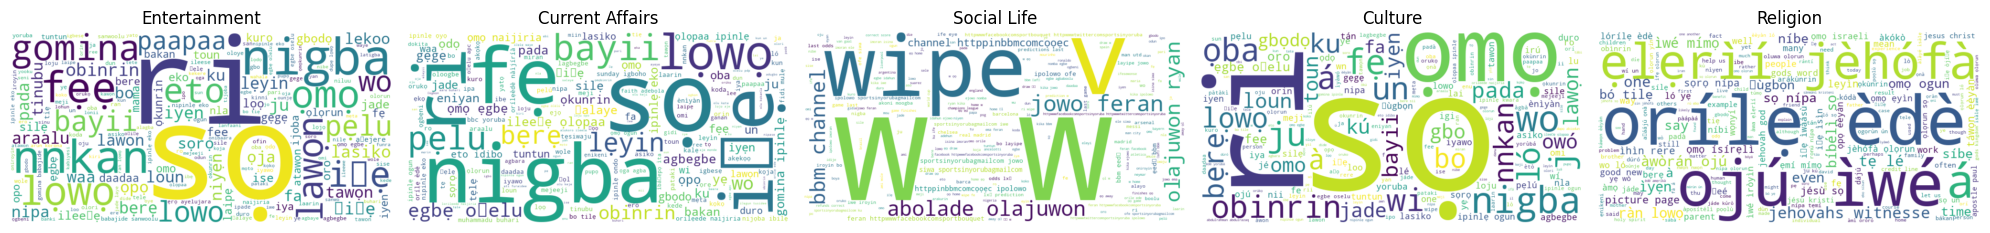

In [20]:
#Word cloud visualization 
entertainment_words = ' '.join(entertainment['content'].values)
curr_affairs_words = ' '.join(curr_affairs['content'].values)
social_life_words = ' '.join(social_life['content'].values)
culture_words = ' '.join(culture['content'].values)
religion_words = ' '.join(religion['content'].values)
from wordcloud import WordCloud
import matplotlib.pyplot as plt
# Generate word clouds for each domain
wordcloud_ent = WordCloud(width=800, height=400, background_color='white').generate(entertainment_words)
wordcloud_curr = WordCloud(width=800, height=400, background_color='white').generate(curr_affairs_words)
wordcloud_soc = WordCloud(width=800, height=400, background_color='white').generate(social_life_words)
wordcloud_cul = WordCloud(width=800, height=400, background_color='white').generate(culture_words)
wordcloud_rel = WordCloud(width=800, height=400, background_color='white').generate(religion_words)
# Plot the word clouds
fig, axs = plt.subplots(1, 5, figsize=(20, 8))  
axs[0].imshow(wordcloud_ent, interpolation='bilinear')
axs[0].set_title('Entertainment')
axs[0].axis('off')
axs[1].imshow(wordcloud_curr, interpolation='bilinear')
axs[1].set_title('Current Affairs')
axs[1].axis('off') 
axs[2].imshow(wordcloud_soc, interpolation='bilinear')
axs[2].set_title('Social Life')
axs[2].axis('off') 
axs[3].imshow(wordcloud_cul, interpolation='bilinear')
axs[3].set_title('Culture')
axs[3].axis('off')
axs[4].imshow(wordcloud_rel, interpolation='bilinear')
axs[4].set_title('Religion')
axs[4].axis('off')
plt.tight_layout() 
plt.show()


In [49]:
from collections import Counter
import numpy as np
from math import log2
import matplotlib.pyplot as plt

# Tone mapping
tone_map = {
    "á": "H", "é": "H", "í": "H", "ó": "H", "ú": "H", 
    "à": "L", "è": "L", "ì": "L", "ò": "L", "ù": "L",
    "a": "M", "e": "M", "i": "M", "o": "M", "u": "M"  # fallback mid
}

# Extract tones from text
def extract_tones(text):
    return [tone_map.get(ch, None) for ch in text if ch in tone_map]

# Tone distribution
def tone_distribution(texts):
    tones = [t for txt in texts for t in extract_tones(txt)]
    freq = Counter(tones)
    total = sum(freq.values())
    return {tone: round(count/total, 3) for tone, count in freq.items()}

# Tone transition matrix
def tone_transition_matrix(texts):
    tones = [t for txt in texts for t in extract_tones(txt)]
    transitions = Counter(zip(tones, tones[1:]))
    tones_set = ["H","M","L"]
    matrix = {t1:{t2:0 for t2 in tones_set} for t1 in tones_set}
    for (t1, t2), count in transitions.items():
        matrix[t1][t2] += count
    return matrix

# Tone entropy
def tone_entropy(texts):
    tones = [t for txt in texts for t in extract_tones(txt)]
    freq = Counter(tones)
    total = sum(freq.values())
    return -sum((c/total) * log2(c/total) for c in freq.values()) if total > 0 else 0

# Tone pattern for each content
def get_tone_pattern(word):
    return ''.join(tone_map.get(char, '') for char in word if char in tone_map)

# Apply tone pattern to dataframes
for df in [entertainment, curr_affairs, social_life, culture, religion]:
    df['tone_pattern'] = df['content'].apply(get_tone_pattern)


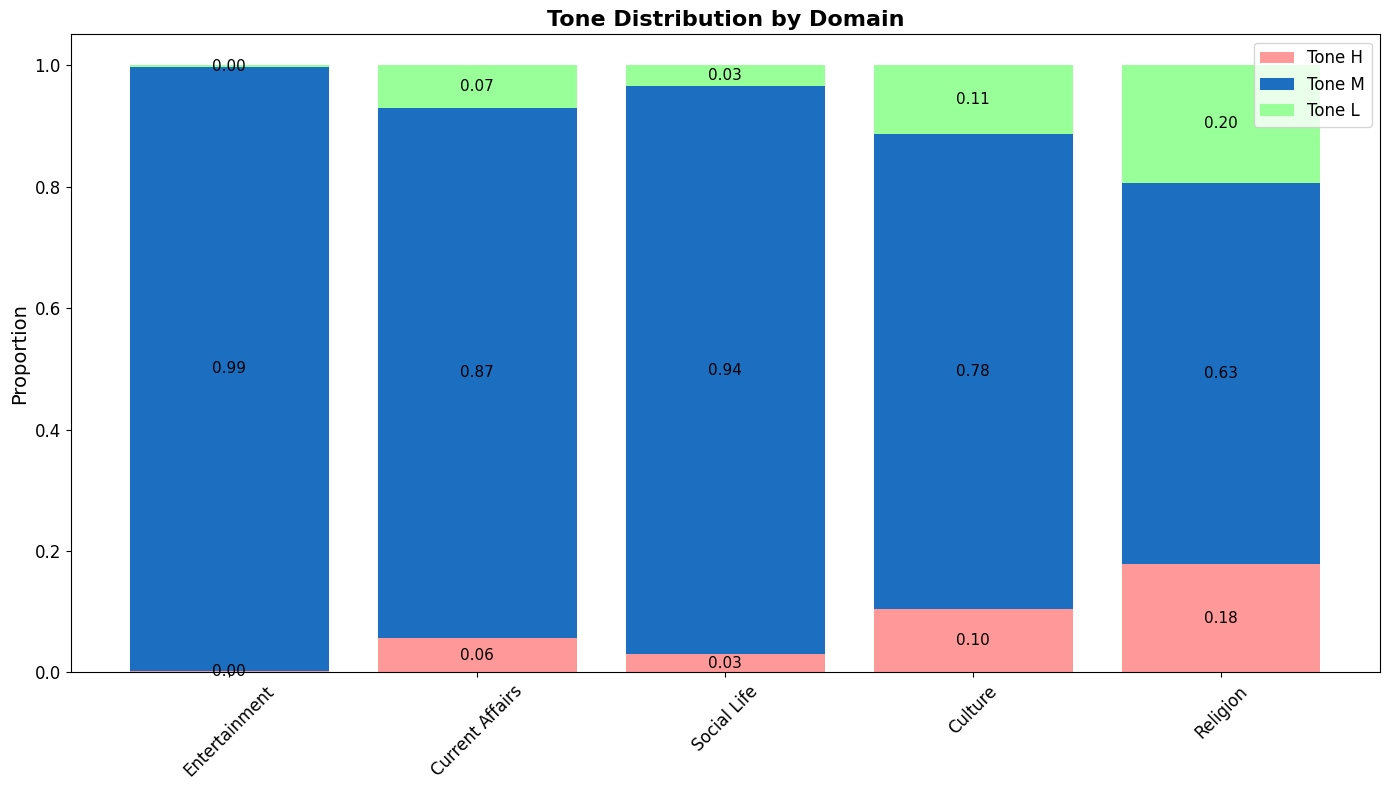

In [50]:
domains = ['Entertainment', 'Current Affairs', 'Social Life', 'Culture', 'Religion']

tone_distributions = [
    tone_distribution(entertainment['content'].values),
    tone_distribution(curr_affairs['content'].values),
    tone_distribution(social_life['content'].values),
    tone_distribution(culture['content'].values),
    tone_distribution(religion['content'].values)
]

tones = ['H', 'M', 'L']
tone_vals = {tone: [td.get(tone, 0) for td in tone_distributions] for tone in tones}
fig, ax = plt.subplots(figsize=(14,8))

bottom = np.zeros(len(domains))
colors = {'H':'#ff9999', 'M':"#1B6EC0", 'L':'#99ff99'}  # distinguishable colors

for tone in tones:
    ax.bar(domains, tone_vals[tone], label=f'Tone {tone}', bottom=bottom, color=colors[tone])
    # Annotate each bar
    for i, val in enumerate(tone_vals[tone]):
        if val > 0:
            ax.text(
                i,
                bottom[i] + val / 2,
                f"{val:.2f}",
                ha='center',
                va='center',
                fontsize=11,
                color='black'
            )
    bottom += np.array(tone_vals[tone])

ax.set_ylabel('Proportion', fontsize=14)
ax.set_title('Tone Distribution by Domain', fontsize=16, fontweight='bold')
ax.legend(fontsize=12)
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

plt.savefig("tone_distribution_by_domain.png", dpi=300, bbox_inches="tight")
plt.show()


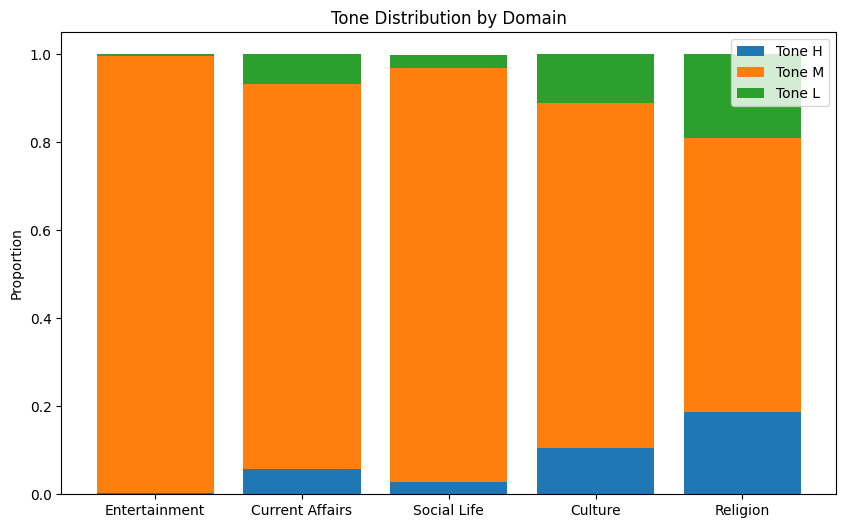

In [21]:
# Simplified tone map (extend for mid tones)
from collections import Counter
import numpy as np
from math import log2
tone_map = {
    "á": "H", "é": "H", "í": "H", "ó": "H", "ú": "H", 
    "à": "L", "è": "L", "ì": "L", "ò": "L", "ù": "L",
    "a": "M", "e": "M", "i": "M", "o": "M", "u": "M"  # fallback mid
}
def extract_tones(text):
    return [tone_map.get(ch, None) for ch in text if ch in tone_map]

def tone_distribution(texts):
    tones = [t for txt in texts for t in extract_tones(txt)]
    freq = Counter(tones)
    total = sum(freq.values())
    return {tone: round(count/total, 3) for tone, count in freq.items()}

def tone_transition_matrix(texts):
    tones = [t for txt in texts for t in extract_tones(txt)]
    transitions = Counter(zip(tones, tones[1:]))
    tones_set = ["H","M","L"]
    matrix = {t1:{t2:0 for t2 in tones_set} for t1 in tones_set}
    for (t1, t2), count in transitions.items():
        matrix[t1][t2] += count
    return matrix

def tone_entropy(texts):
    tones = [t for txt in texts for t in extract_tones(txt)]
    freq = Counter(tones)
    total = sum(freq.values())
    return -sum((c/total) * log2(c/total) for c in freq.values())



def get_tone_pattern(word):
    return ''.join(tone_map.get(char, '') for char in word if char in tone_map) 


entertainment['tone_pattern'] = entertainment['content'].apply(get_tone_pattern)
curr_affairs['tone_pattern'] = curr_affairs['content'].apply(get_tone_pattern)
social_life['tone_pattern'] = social_life['content'].apply(get_tone_pattern)
culture['tone_pattern'] = culture['content'].apply(get_tone_pattern)    
religion['tone_pattern'] = religion['content'].apply(get_tone_pattern) 
entertainment['tone_pattern'].head()
tone_distribution(entertainment['content'].values), tone_distribution(curr_affairs['content'].values), tone_distribution(social_life['content'].values), tone_distribution(culture['content'].values), tone_distribution(religion['content'].values)
tone_transition_matrix(entertainment['content'].values), tone_transition_matrix(curr_affairs['content'].values), tone_transition_matrix(social_life['content'].values), tone_transition_matrix(culture['content'].values), tone_transition_matrix(religion['content'].values)
tone_entropy(entertainment['content'].values), tone_entropy(curr_affairs['content'].values), tone_entropy(social_life['content'].values), tone_entropy(culture['content'].values), tone_entropy(religion['content'].values) 
import matplotlib.pyplot as plt

domains = ['Entertainment', 'Current Affairs', 'Social Life', 'Culture', 'Religion']
tone_distributions = [
    tone_distribution(entertainment['content'].values),
    tone_distribution(curr_affairs['content'].values),
    tone_distribution(social_life['content'].values),
    tone_distribution(culture['content'].values),
    tone_distribution(religion['content'].values)
]

tones = ['H', 'M', 'L']
tone_vals = {tone: [td.get(tone, 0) for td in tone_distributions] for tone in tones}

fig, ax = plt.subplots(figsize=(10,6))
bottom = np.zeros(len(domains))
for tone in tones:
    ax.bar(domains, tone_vals[tone], label=f'Tone {tone}', bottom=bottom)
    bottom += np.array(tone_vals[tone])

ax.set_ylabel('Proportion')
ax.set_title('Tone Distribution by Domain')
ax.legend()
plt.show()

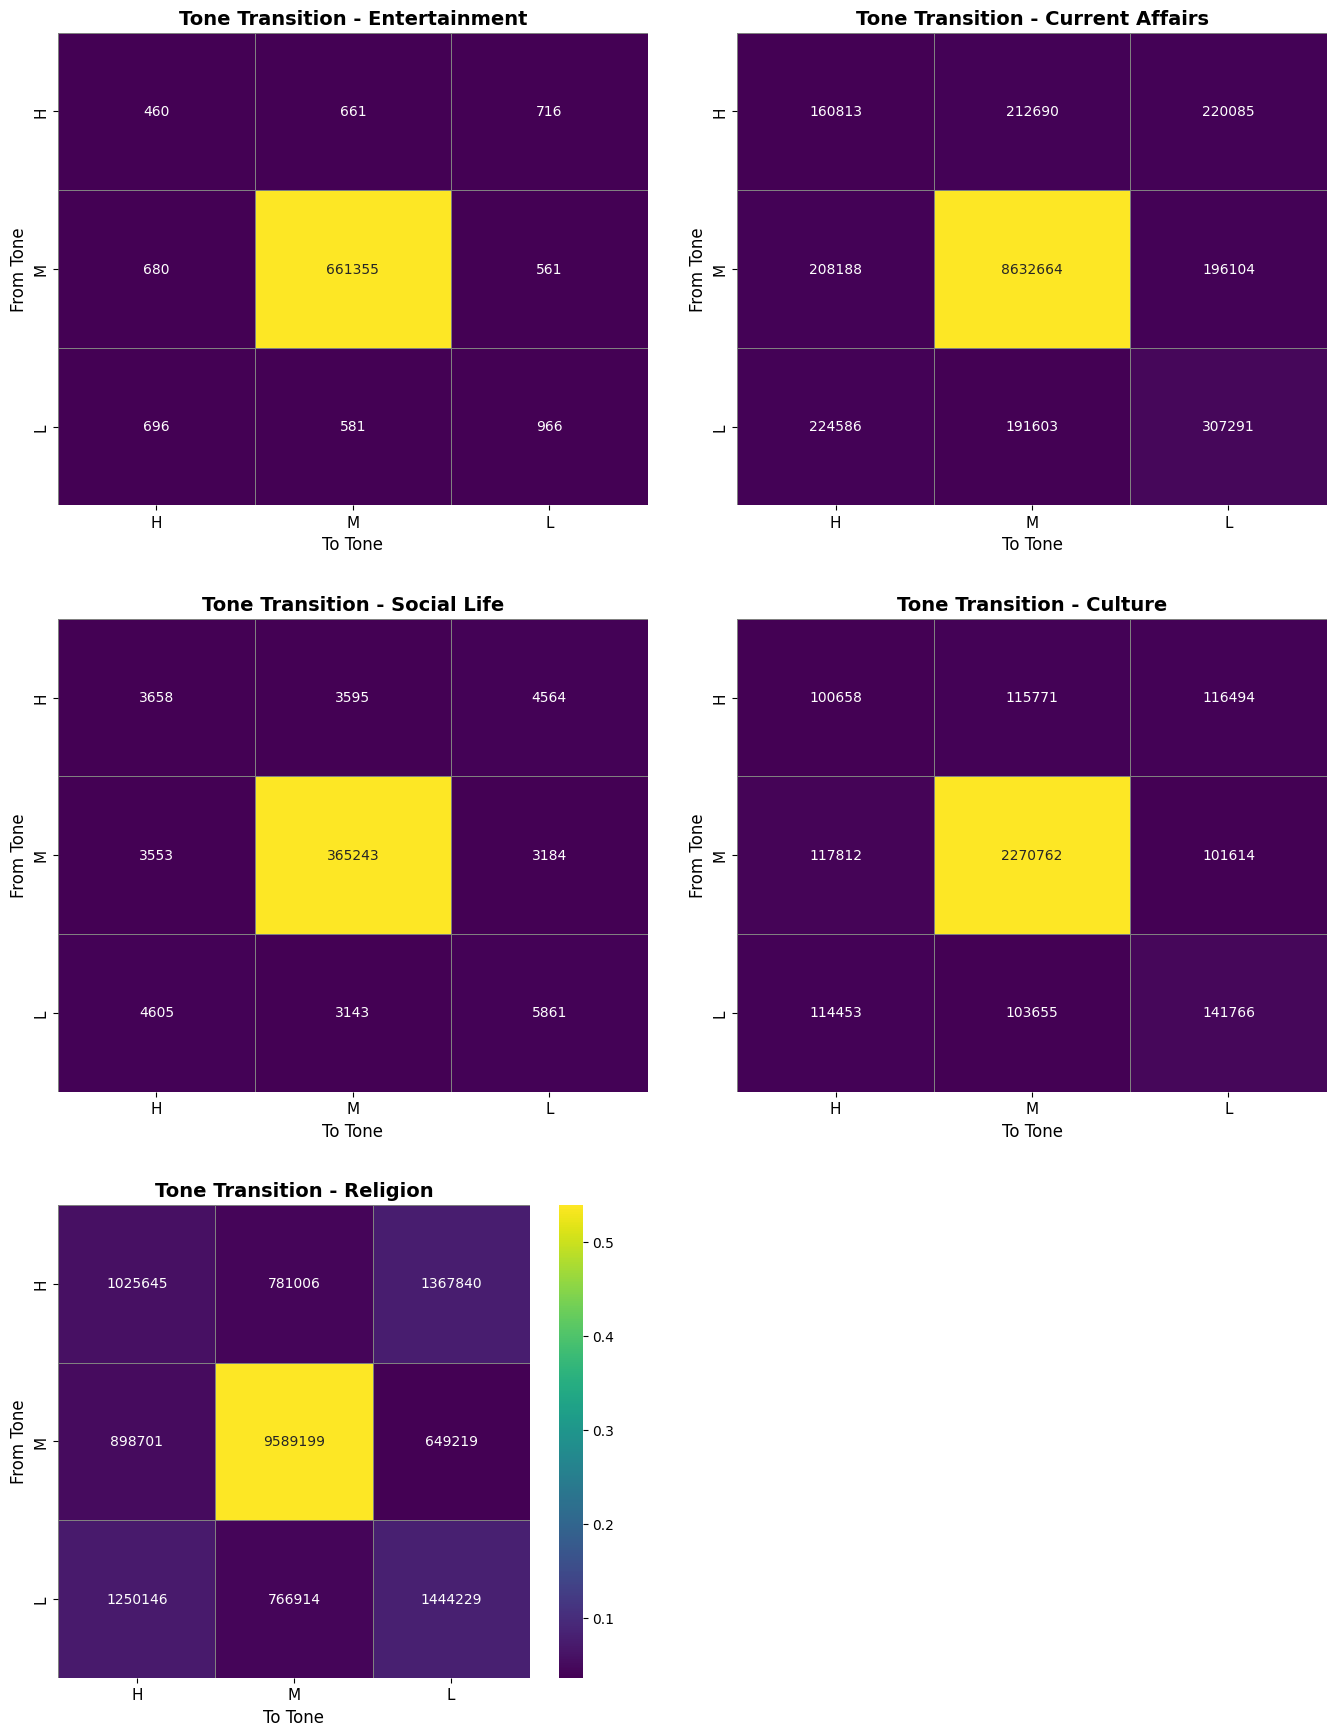

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

tones = ['H', 'M', 'L']

# Compute transition matrices
tone_transition_matrices = [
    tone_transition_matrix(entertainment['content'].values),
    tone_transition_matrix(curr_affairs['content'].values),
    tone_transition_matrix(social_life['content'].values),
    tone_transition_matrix(culture['content'].values),
    tone_transition_matrix(religion['content'].values)
]

# Create 3x2 subplot grid
fig, axs = plt.subplots(3, 2, figsize=(14, 18))
axs = axs.flatten()  # flatten for easy indexing

for i, (matrix, domain) in enumerate(zip(tone_transition_matrices, domains)):
    mat = np.array([[matrix[t1][t2] for t2 in tones] for t1 in tones])
    
    # Normalize to proportions
    mat_prop = mat / mat.sum() if mat.sum() > 0 else mat
    
    sns.heatmap(
        mat_prop,
        annot=mat,
        fmt='d',
        cmap='viridis',
        xticklabels=tones,
        yticklabels=tones,
        ax=axs[i],
        cbar=i==4,  # show colorbar only on last plot
        linewidths=0.5,
        linecolor='gray'
    )
    
    axs[i].set_title(f'Tone Transition - {domain}', fontsize=14, fontweight='bold')
    axs[i].set_xlabel('To Tone', fontsize=12)
    axs[i].set_ylabel('From Tone', fontsize=12)
    axs[i].tick_params(axis='x', labelsize=11)
    axs[i].tick_params(axis='y', labelsize=11)

# Hide the 6th (empty) subplot
axs[5].axis('off')

plt.tight_layout(pad=3.0)
plt.savefig("tone_transition_heatmaps_3x2.png", dpi=300, bbox_inches="tight")
plt.show()


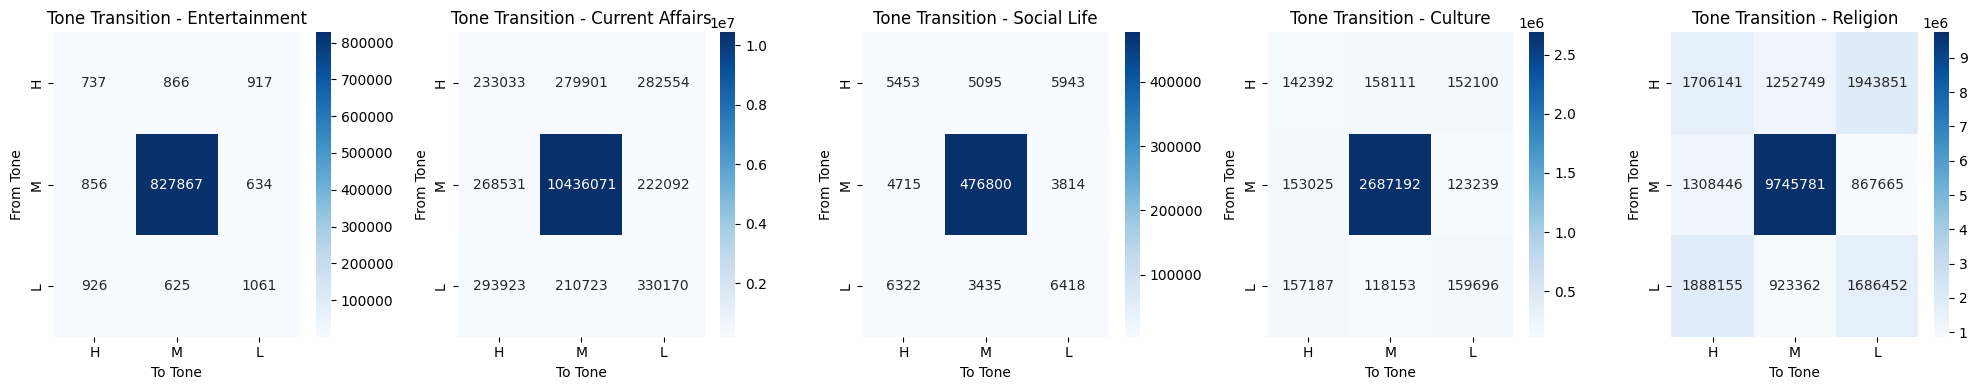

In [ ]:
tone_transition_matrices = [
    tone_transition_matrix(entertainment['content'].values),
    tone_transition_matrix(curr_affairs['content'].values),
    tone_transition_matrix(social_life['content'].values),
    tone_transition_matrix(culture['content'].values),
    tone_transition_matrix(religion['content'].values)
]
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
tones = ['H', 'M', 'L']
fig, axs = plt.subplots(1, 5, figsize=(20, 10))
for i, (matrix, domain) in enumerate(zip(tone_transition_matrices, domains)):
    mat = np.array([[matrix[t1][t2] for t2 in tones] for t1 in tones])
    sns.heatmap(mat, annot=True, fmt='d', cmap='Blues', xticklabels=tones, yticklabels=tones, ax=axs[i])
    axs[i].set_title(f'Tone Transition - {domain}')
    axs[i].set_xlabel('To Tone')
    axs[i].set_ylabel('From Tone')
plt.tight_layout()
plt.show()



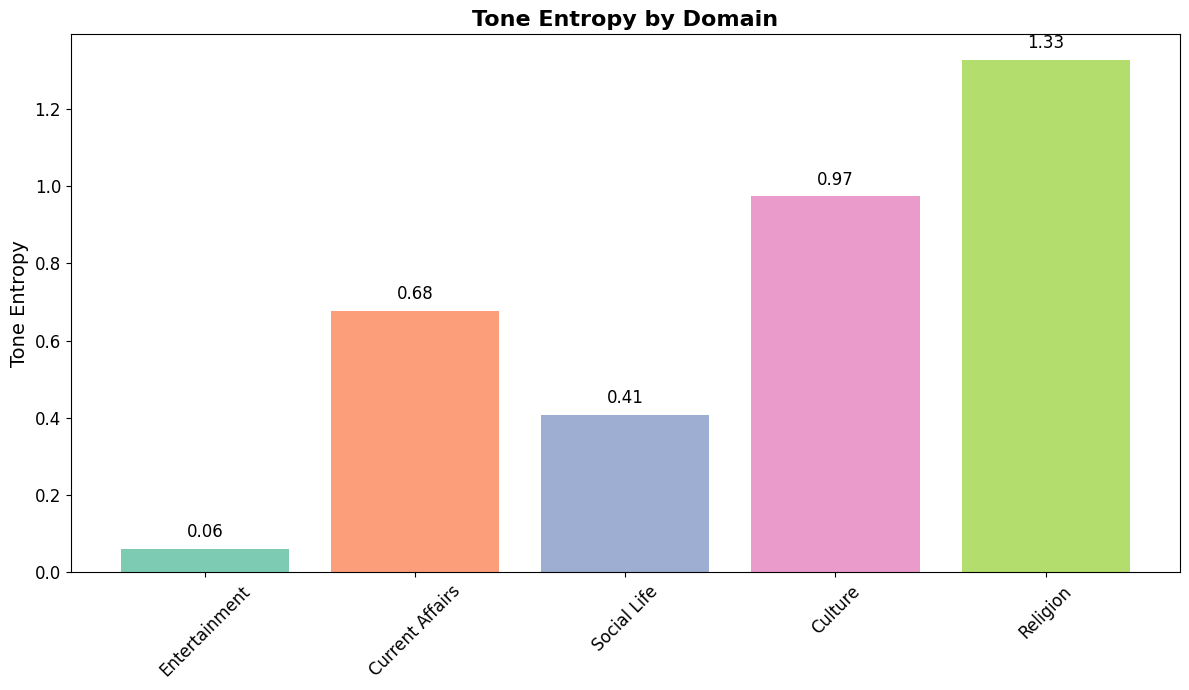

In [54]:
import matplotlib.pyplot as plt
import numpy as np

# Compute tone entropy values
tone_entropy_values = [
    tone_entropy(entertainment['content'].values),
    tone_entropy(curr_affairs['content'].values),
    tone_entropy(social_life['content'].values),
    tone_entropy(culture['content'].values),
    tone_entropy(religion['content'].values)
]

# Plot
fig, ax = plt.subplots(figsize=(12, 7))
colors = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854']  # distinguishable, manuscript-friendly

bars = ax.bar(domains, tone_entropy_values, color=colors, alpha=0.85)

# Labels and title
ax.set_ylabel('Tone Entropy', fontsize=14)
ax.set_title('Tone Entropy by Domain', fontsize=16, fontweight='bold')
ax.tick_params(axis='x', labelsize=12, rotation=45)
ax.tick_params(axis='y', labelsize=12)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + 0.02,  # small offset above bar
        f"{height:.2f}",
        ha='center',
        va='bottom',
        fontsize=12
    )

plt.tight_layout()
plt.savefig("tone_entropy_by_domain.png", dpi=300, bbox_inches="tight")
plt.show()


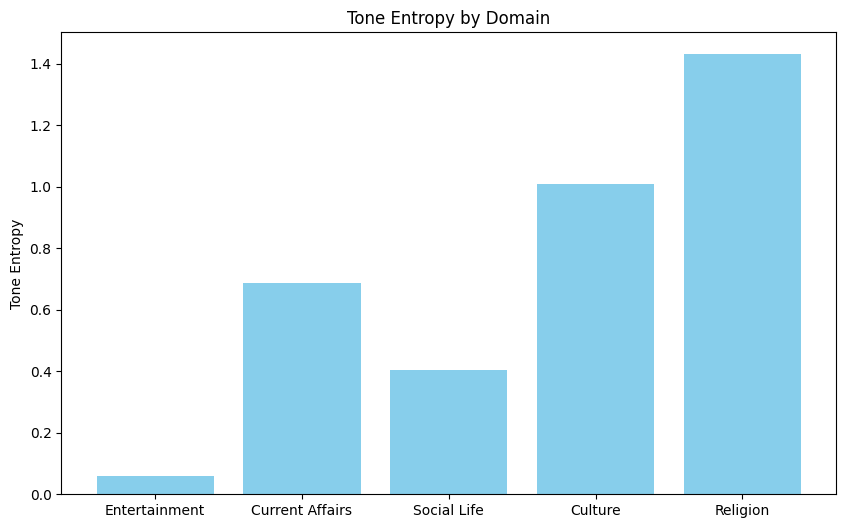

In [29]:
tone_entropy_values = [
    tone_entropy(entertainment['content'].values),
    tone_entropy(curr_affairs['content'].values),
    tone_entropy(social_life['content'].values),
    tone_entropy(culture['content'].values),
    tone_entropy(religion['content'].values)
]   
fig, ax = plt.subplots(figsize=(10,6))  
bar = ax.bar(domains, tone_entropy_values, color='skyblue')
ax.set_ylabel('Tone Entropy')
ax.set_title('Tone Entropy by Domain')
plt.show()

In [55]:
from sklearn.feature_extraction.text import TfidfVectorizer

def top_tfidf_terms(texts, top_k=20):
    vectorizer = TfidfVectorizer(max_features=5000)
    X = vectorizer.fit_transform(texts)
    scores = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)
    return sorted(scores, key=lambda x: x[1], reverse=True)[:top_k]

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

def lda_topics(texts, n_topics=5, n_words=10):
    vectorizer = CountVectorizer(max_features=5000)
    X = vectorizer.fit_transform(texts)
    lda = LatentDirichletAllocation(n_components=n_topics, random_state=42)
    lda.fit(X)
    words = vectorizer.get_feature_names_out()
    topics = []
    for topic in lda.components_:
        top_words = [words[i] for i in topic.argsort()[-n_words:]]
        topics.append(top_words)
    return topics

import math

def compute_pmi(tokens, window=2, min_count=5):
    vocab = Counter(tokens)
    total = sum(vocab.values())
    bigrams = Counter(zip(tokens, tokens[1:]))
    pmi_scores = {}
    for (w1, w2), count in bigrams.items():
        if count >= min_count:
            p_w1 = vocab[w1]/total
            p_w2 = vocab[w2]/total
            p_w1w2 = count/total
            pmi_scores[(w1,w2)] = math.log2(p_w1w2/(p_w1*p_w2))
    return sorted(pmi_scores.items(), key=lambda x: x[1], reverse=True)[:20]

In [56]:
# for each domain
ent_tfidf = top_tfidf_terms(entertainment['content'].values)
curr_tfidf = top_tfidf_terms(curr_affairs['content'].values)
soc_tfidf = top_tfidf_terms(social_life['content'].values)
cul_tfidf = top_tfidf_terms(culture['content'].values)
rel_tfidf = top_tfidf_terms(religion['content'].values)
ent_lda = lda_topics(entertainment['content'].values)
curr_lda = lda_topics(curr_affairs['content'].values)   
soc_lda = lda_topics(social_life['content'].values)
cul_lda = lda_topics(culture['content'].values)
rel_lda = lda_topics(religion['content'].values)
ent_pmi = compute_pmi(yoruba_tokenizer(all_ent))
curr_pmi = compute_pmi(yoruba_tokenizer(all_curr))
soc_pmi = compute_pmi(yoruba_tokenizer(all_soc))
cul_pmi = compute_pmi(yoruba_tokenizer(all_cul))
rel_pmi = compute_pmi(yoruba_tokenizer(all_rel))    
ent_tfidf, curr_tfidf, soc_tfidf, cul_tfidf, rel_tfidf
ent_lda, curr_lda, soc_lda, cul_lda, rel_lda   

ent_pmi, curr_pmi, soc_pmi, cul_pmi, rel_pmi





([(('ajọgbo', 'akia'), 15.80626766073016),
  (('bagauda', 'kaltho'), 15.543233254896368),
  (('simba', 'tvs'), 15.543233254896368),
  (('medium', 'enterprises'), 15.543233254896368),
  (('wuraọla', 'aṣakẹ'), 15.543233254896368),
  (('small', 'medium'), 15.320840833559918),
  (('tafawa', 'balewa'), 15.320840833559918),
  (('russian', 'federation'), 15.320840833559918),
  (('hand', 'hope'), 15.320840833559918),
  (('niṣu', 'lọka'), 15.128195755617524),
  (('sikiratu', 'ejide'), 15.128195755617524),
  (('farm', 'settlement'), 15.128195755617524),
  (('senatorial', 'district'), 15.057806427726126),
  (('abu', 'nolla'), 15.057806427726126),
  (('sunkere', 'fakere'), 14.958270754175212),
  (('permanent', 'secretary'), 14.958270754175212),
  (('port', 'harcourt'), 14.958270754175212),
  (('frank', 'mba'), 14.958270754175212),
  (('jori', 'ahun'), 14.958270754175212),
  (('hong', 'kong'), 14.958270754175212)],
 [(('koton', 'karfe'), 19.80838762757014),
  (('tàdí', 'mẹyìn'), 19.80838762757014),

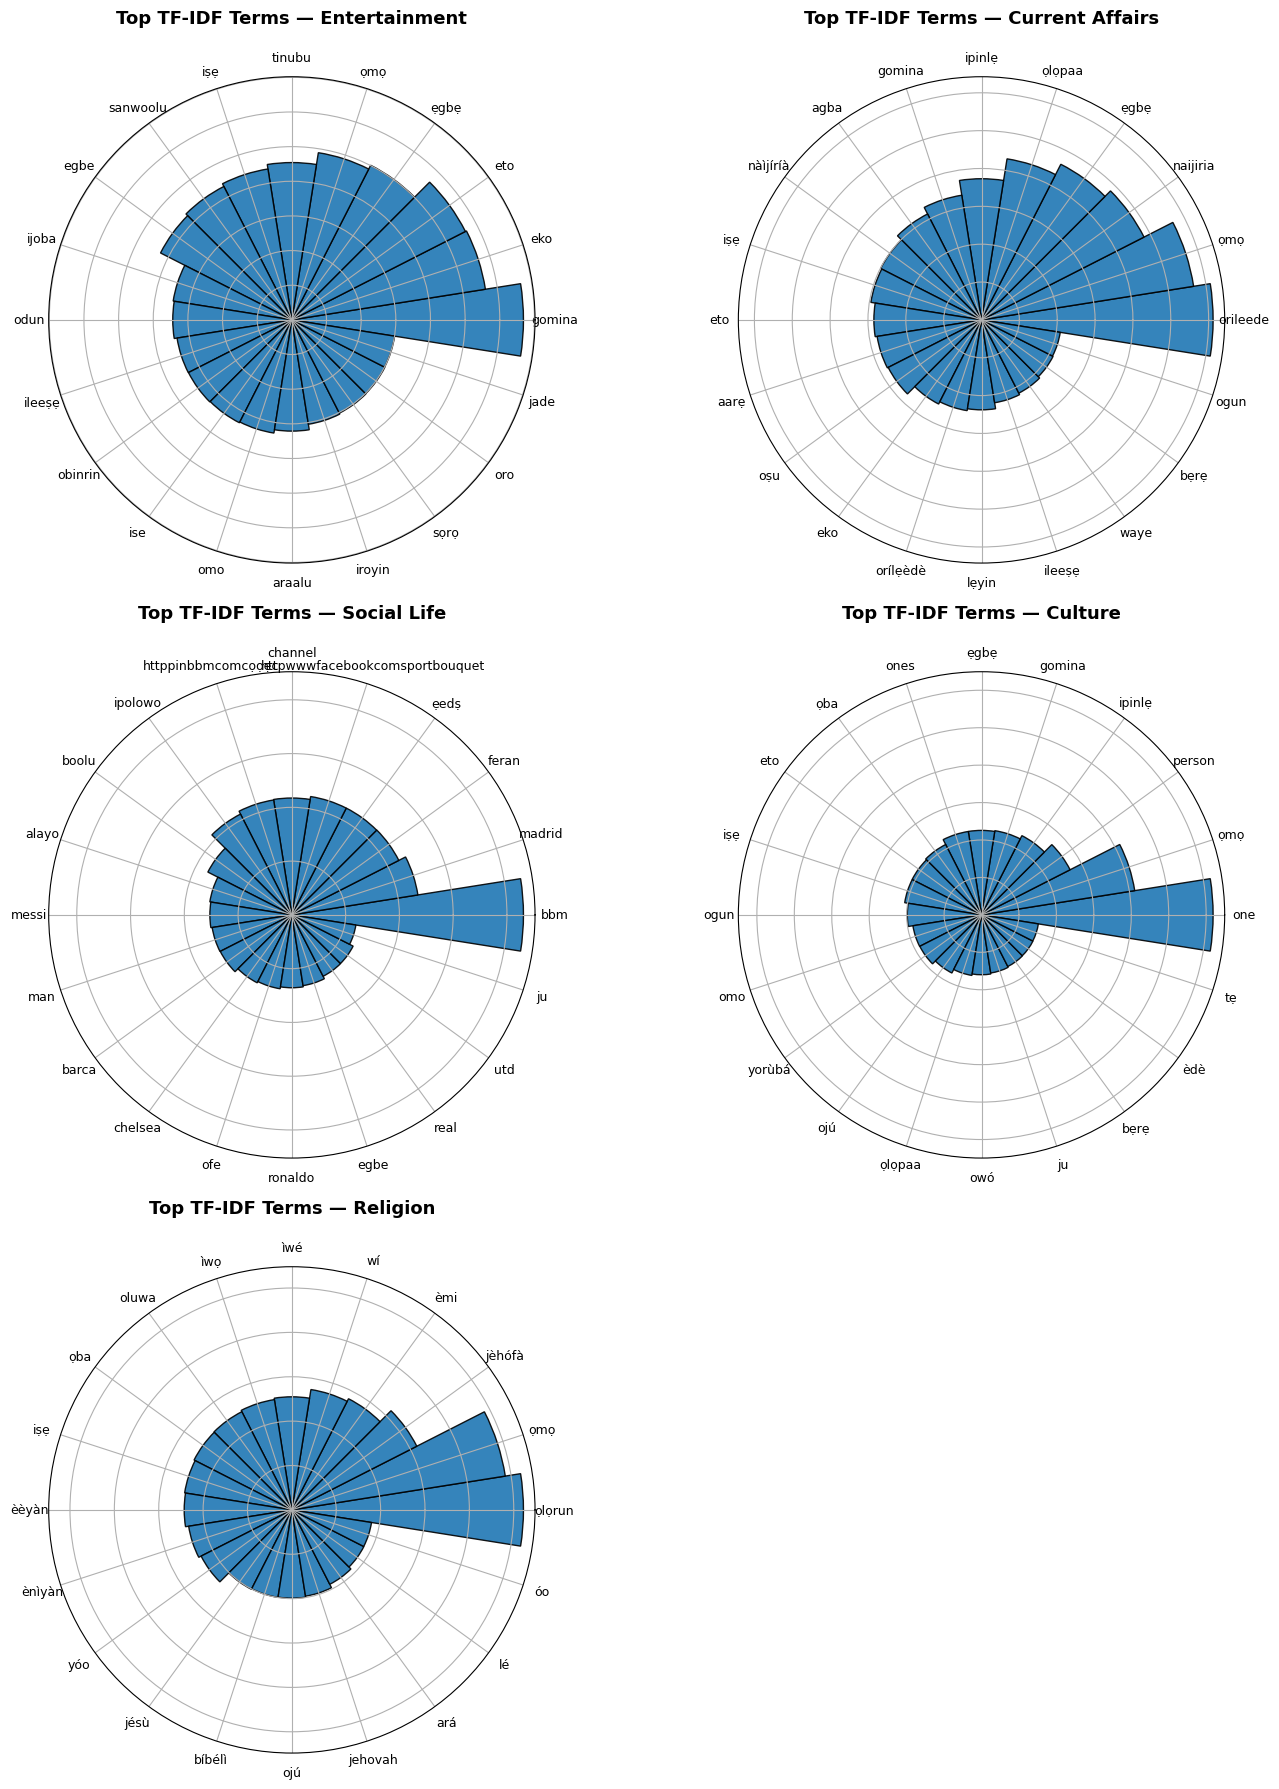

In [57]:
import numpy as np
import matplotlib.pyplot as plt

domain_names = ['Entertainment', 'Current Affairs', 'Social Life', 'Culture', 'Religion']
tfidf_lists = [ent_tfidf, curr_tfidf, soc_tfidf, cul_tfidf, rel_tfidf]

# Create 3x2 grid with polar projection
fig, axs = plt.subplots(
    3, 2,
    figsize=(14, 18),
    subplot_kw=dict(polar=True)
)

axs = axs.flatten()

for i, (domain, tfidf) in enumerate(zip(domain_names, tfidf_lists)):
    words, scores = zip(*tfidf)

    angles = np.linspace(0, 2*np.pi, len(words), endpoint=False)
    scores = np.array(scores)

    axs[i].bar(
        angles,
        scores,
        width=2*np.pi/len(words),
        color='tab:blue',
        edgecolor='black',
        alpha=0.9
    )

    axs[i].set_xticks(angles)
    axs[i].set_xticklabels(words, fontsize=9)
    axs[i].set_yticklabels([])

    axs[i].set_title(
        f"Top TF-IDF Terms — {domain}",
        fontsize=13,
        fontweight='bold',
        pad=20
    )

# Remove unused subplot (6th slot)
fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()


In [59]:
ent_lda

[['sanwoolu',
  'olori',
  'waye',
  'gomina',
  'odun',
  'oba',
  'eto',
  'mama',
  'ayeye',
  'eko'],
 ['ọkunrin',
  'lẹyin',
  'oṣu',
  'obinrin',
  'ọba',
  'ọlọpaa',
  'tawọn',
  'gomina',
  'sọrọ',
  'ọmọ'],
 ['sanwoolu',
  'omi',
  'mama',
  'ileeṣẹ',
  'ọlọja',
  'iyalọja',
  'eko',
  'oju',
  'iṣẹ',
  'ọja'],
 ['lawon',
  'eto',
  'eko',
  'oro',
  'odun',
  'ijoba',
  'omo',
  'gomina',
  'ise',
  'egbe'],
 ['aṣejere',
  'bẹrẹ',
  'ileeṣẹ',
  'ṣiṣẹ',
  'eko',
  'gomina',
  'eto',
  'ọmọ',
  'iṣẹ',
  'ẹgbẹ']]

In [ ]:
# Visualize top TF-IDF terms for each domain
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 5, figsize=(24, 6))
domain_names = ['Entertainment', 'Current Affairs', 'Social Life', 'Culture', 'Religion']
tfidf_lists = [ent_tfidf, curr_tfidf, soc_tfidf, cul_tfidf, rel_tfidf]

for i, (ax, domain, tfidf) in enumerate(zip(axs, domain_names, tfidf_lists)):
    words, scores = zip(*tfidf)
    ax.bar(words, scores)
    ax.set_title(domain)
    ax.set_xticklabels(words, rotation=90)
    ax.set_ylabel('TF-IDF Score')

plt.tight_layout()
plt.show()



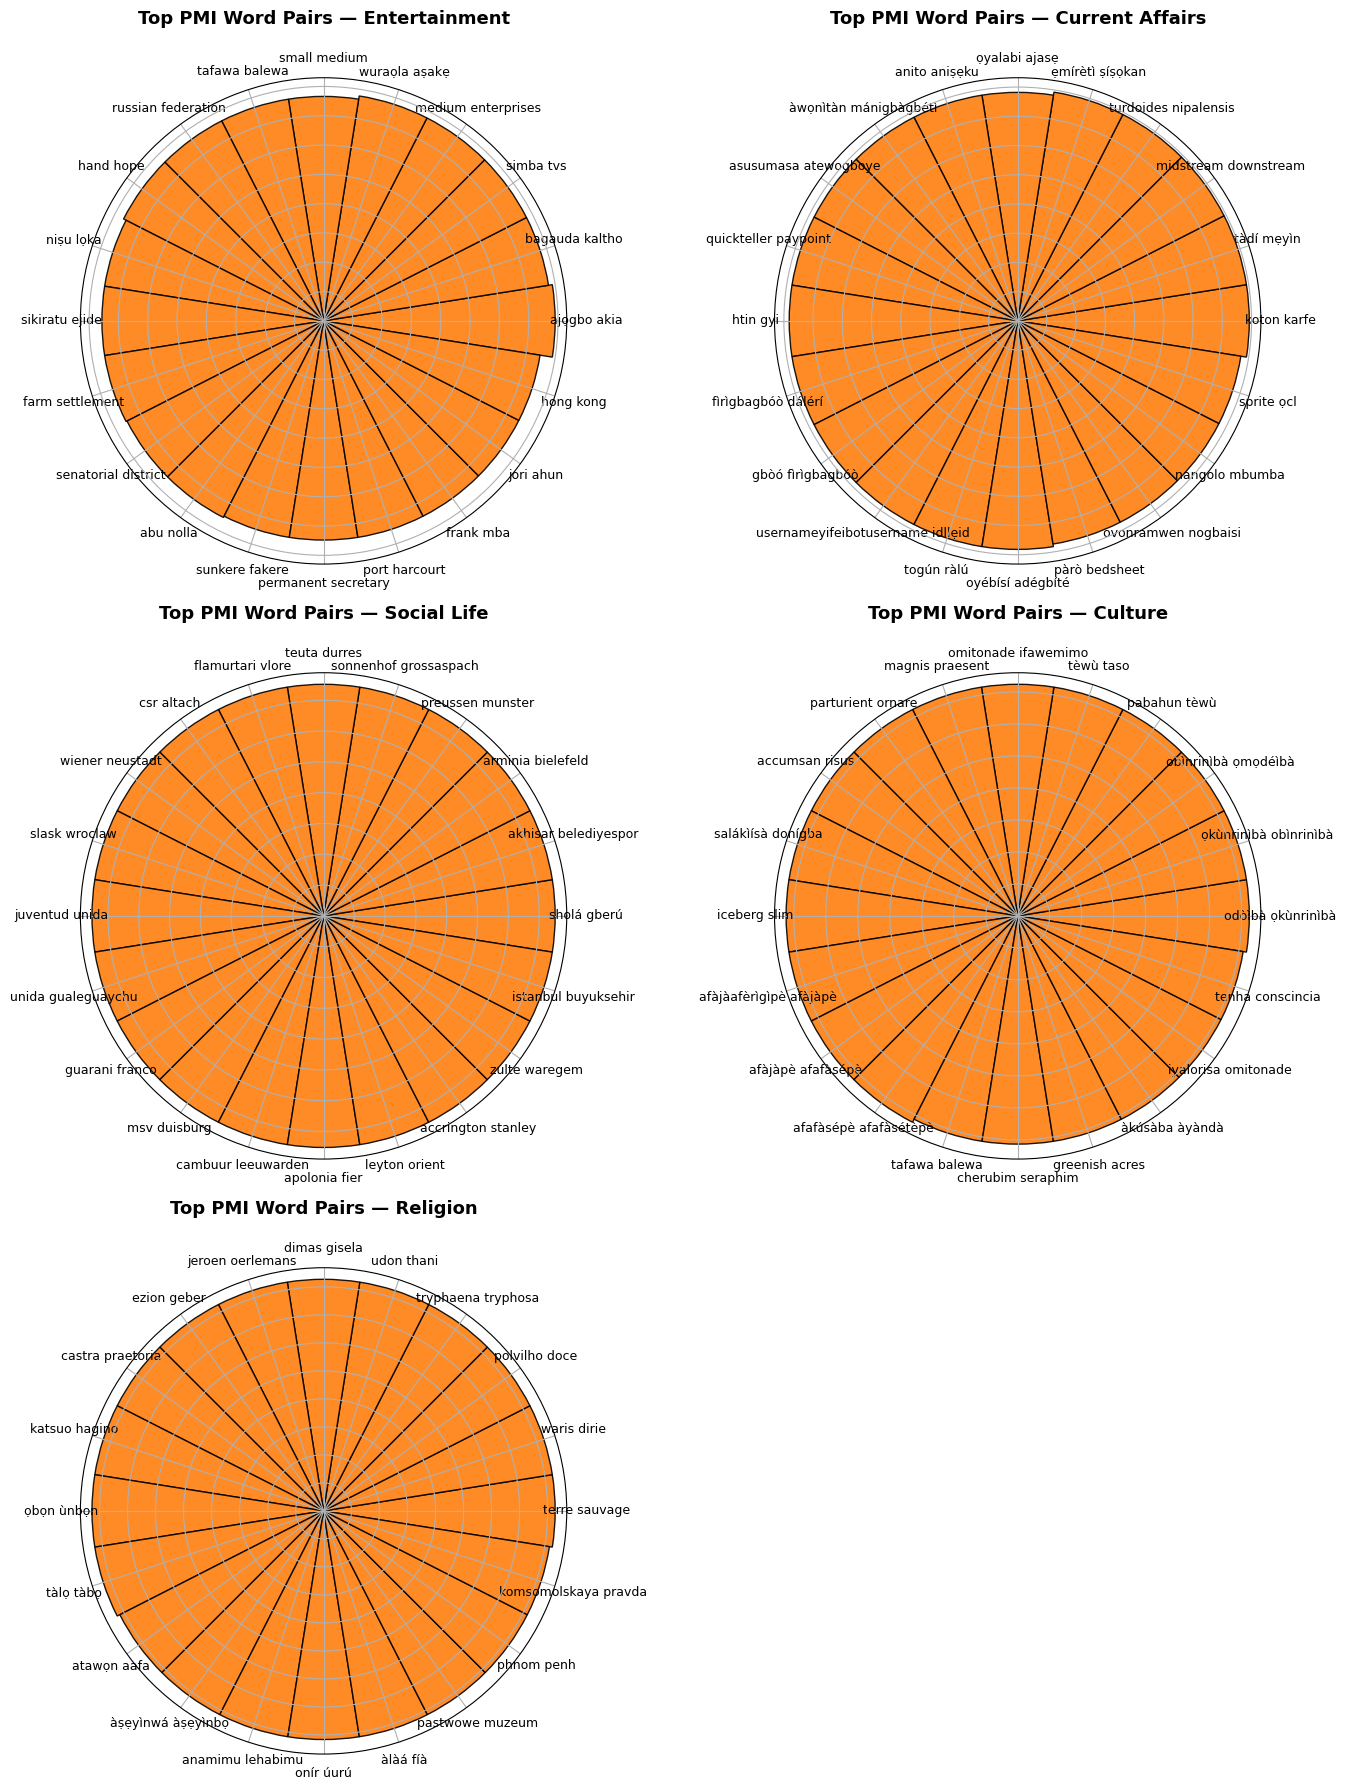

In [60]:
import numpy as np
import matplotlib.pyplot as plt

pmi_lists = [ent_pmi, curr_pmi, soc_pmi, cul_pmi, rel_pmi]
domain_names = ['Entertainment', 'Current Affairs', 'Social Life', 'Culture', 'Religion']

# Create 3x2 polar grid
fig, axs = plt.subplots(
    3, 2,
    figsize=(14, 18),
    subplot_kw=dict(polar=True)
)

axs = axs.flatten()

for i, (domain, pmi) in enumerate(zip(domain_names, pmi_lists)):
    pairs, scores = zip(*pmi)
    word_pairs = [' '.join(pair) for pair in pairs]

    angles = np.linspace(0, 2 * np.pi, len(word_pairs), endpoint=False)
    scores = np.array(scores)

    axs[i].bar(
        angles,
        scores,
        width=2 * np.pi / len(word_pairs),
        color='tab:orange',
        edgecolor='black',
        alpha=0.9
    )

    axs[i].set_xticks(angles)
    axs[i].set_xticklabels(word_pairs, fontsize=9)
    axs[i].set_yticklabels([])

    axs[i].set_title(
        f"Top PMI Word Pairs — {domain}",
        fontsize=13,
        fontweight='bold',
        pad=20
    )

# Remove unused subplot (6th position)
fig.delaxes(axs[-1])

plt.tight_layout()
plt.show()
